# Capstone Project - The Battle of the Neighborhoods (Week 2) - Nottingham UK
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
    * [Crime in Nottingham](#Crime_Nottm)
    * [Venues in Nottingham](#Venue_Nottm)
    * [LSOA Revisited](#LSOA)
* [Methodology](#Methodology)
* [Results](#Results)
* [Discussion](#Discussion)
* [Conclusion](#Conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Nottingham is a medium sized city in the East Midland of the England in the UK.   It has a thriving and lively nightlife with a wide and eclectic range of restaurants, cafes, bars and clubs catering to many different categories of people including the student of two universities.  The City is a chosen weekend destination for groups of young people from all over the UK.

Nottingham also has, like many cities in the UK, crime issues, with parts of the city and its environs exceeding the national crime rate by in excess of 100% (within particular crime categories - see https://www.plumplot.co.uk/Nottingham-violent-crime-statistics.html). 

The requirement in this case is to assess the optimum placement of restaurants / cafes / bars in areas that are more popular for dining and there is regular footfall and to take account of the crime statistics for that location and therefor the safety of customers and property of the given business.  The data search should happen for the boroughs of Nottingham and the connected urban boroughs of Broxtowe, Gedling and Rushcliffe.  It is intended that this data should be used by people who are looking to set up a hospitality business within the environs of Nottingham to help them decide which factors that they will take into account when choosing restaurant location and from that be able to suggest potential sites. 

## Data <a name="data"></a>
Based on the definition of the problem, we need to breakdown the research into two separate areas - the crime in a particular area and corresponding restaurant activity in that area.

### Crime in Nottingam 2019 <a name="Crime_Nottm"></a>

Based on the definition of the problem, we need to know the following type of information:-
*	The number of crimes in a given location
*	The type of crimes in a given location
*	The frequency of crimes in a given location.

Data about recorded crimes is held for each Police force in the UK in the Police Data Portal (https://data.police.uk/).  The portal does provide an API to access the data but this will only provide records for the specified month – if no month is specified then data for the previous month is returned.  Since it is part of the scope of this analysis to include a view on the frequency of the crimes then we need to collect data on more than one time period - preferably over a year.  

The Police Data portal allows the selection and download of CSV files – selecting the Police Force and the Month that the crime was recorded in - to download.  The data is downloaded in a zip file containing CSV files in separate directories for each selected month.  Since this data cannot be accessed directly from Python, it was decided to download locally data relevant to the greater Nottingham area for the whole of the year 2019 and hold this in DB2 for subsequent querying using python. It was decided that only crime data should be downloaded, and that outcomes and stop-and-search data would not have any significance in the analysis the crime rate.

The format of the CSV is described in the in the table below.  From examination of this data it is clear that various fields will not be required in the analysis and as such the last column of the table shows which of the fields should be retained or discarded for use in this analysis.


| Field           | Meaning                                                  | Discard   |
|:--------------- |:---------------------------------------------------------|:----------|
| Crime Id        | Identifier for the individual crime                      | Discard   |
| Month           | The Year and Month that the crime was reported in        | Retain    |
| Reported By     | The force that provided the data about the crime.        | Retain    |
| Falls within    | Currently the force that provided the data about the crime | Discard      |
| Location | Rough description of the location of the Crime | Discard | 
| Latitiude & Longitude | The anonymised coordinates of the crime. | Retain  |
| LSOA Code & Name | References to the Lower Layer Super Output Area that the anonymised point falls into (see later) | Retain   |
| Crime Type    | Categorisation of the crime                           | Retain     |
| Last Outcome    |  reference to whichever of the outcomes associated with the crime occurred most recently.| Discard   |
| Context   | A field provided for forces to provide additional human-readable data about individual crimes. | Discard   |

Fields that are not to be retained are generally those used to identify the individual crime and as such are of no use in the aggregation of the crime information.
The LSOA information is a uses a standard method (according the UK Office of National Statistics) of grouping the crimes into a recognised geographical location.   In particular the naming format allows human readable information regarding which Borough the crime was committed in.

### LSOA and choice of Geographic Grouping
As has been noted each crime has been recorded with the Lower Layer Super Output Area (LSOA) which is a UK standard format for statistical reporting – further information can be found [here](https://geoportal.statistics.gov.uk/datasets/lower-layer-super-output-areas-december-2011-population-weighted-centroids?geometry=-1.607%2C52.888%2C-0.564%2C53.032) .  As an area for geographic grouping the LSOA is somewhat small and as such a larger area geographical grouping may be required. 


### Records to be Discarded
Given that the selection criteria are for the Month and Police force, the downloaded CSV files contain data regarding crimes committed outside the Greater Nottingham area.  In this case it was decided that records with LSOA indicating that the crime was committed outside of the urban boroughs in or contiguous to Nottingham (Nottingham, Broxtowe, Gedling and Rushcliffe) should be discarded from DB2 in order to cut down on Storage requirements.

Below is a first look at the raw crime data held in DB2:


In [1]:
import ibm_db
import ibm_db_dbi
import pandas as pd
import numpy as np

# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
mpl.style.use('ggplot') # optional: for ggplot-like style

from sklearn.cluster import KMeans
# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0


Matplotlib version:  3.1.1


In [2]:
colors

<module 'matplotlib.colors' from '/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/matplotlib/colors.py'>

DB2 Service Credentials

In [3]:
#Replace the placeholder values with the actuals for Db2 Service Credentials
dsn_driver = "{IBM DB2 ODBC DRIVER}"
dsn_database = "BLUDB"            # e.g. "BLUDB"
dsn_hostname = "dashdb-txn-sbox-yp-lon02-02.services.eu-gb.bluemix.net"            # e.g.: "dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net"
dsn_port = "50000"                    # e.g. "50000" 
dsn_protocol = "TCPIP"            # i.e. "TCPIP"
dsn_uid = "ctz66893"                 # e.g. "abc12345"
dsn_pwd = "bts-x39p7p8fwlm0"  

In [4]:
dsn = (
    "DRIVER={0};"
    "DATABASE={1};"
    "HOSTNAME={2};"
    "PORT={3};"
    "PROTOCOL={4};"
    "UID={5};"
    "PWD={6};").format(dsn_driver, dsn_database, dsn_hostname, dsn_port, dsn_protocol, dsn_uid, dsn_pwd)

try:
    conn = ibm_db.connect(dsn, "", "")
    print ("Connected to database: ", dsn_database, "as user: ", dsn_uid, "on host: ", dsn_hostname)

except:
    print ("Unable to connect: ", ibm_db.conn_errormsg() )

Connected to database:  BLUDB as user:  ctz66893 on host:  dashdb-txn-sbox-yp-lon02-02.services.eu-gb.bluemix.net


In [5]:
#connection for pandas
pconn = ibm_db_dbi.Connection(conn)

#query statement to retrieve all rows in in the Crime Table, with the MSOA code and object type assigned
selectQuery = "select* from NOTTINGHAM_CRIME_2019"

#retrieve the query results into a pandas dataframe
NOTTM_CRIMEdf = pd.read_sql(selectQuery, pconn)

#print just the LNAME for first row in the pandas data frame
NOTTM_CRIMEdf.head()

MONTH             REPORTED_BY  LONGITUDE   LATITUDE  \
0  2019-01  Nottinghamshire Police  -1.320816  53.032832   
1  2019-01  Nottinghamshire Police  -1.312767  53.043870   
2  2019-01  Nottinghamshire Police  -1.309872  53.040248   
3  2019-01  Nottinghamshire Police  -1.309787  53.032463   
4  2019-01  Nottinghamshire Police  -1.317157  53.044533   

                            LOCATION  LSOA_CODE      LSOA_NAME  \
0             On or near Stoney Lane  E01028092  Broxtowe 001A   
1              On or near Broad Lane  E01028092  Broxtowe 001A   
2  On or near Sports/Recreation Area  E01028092  Broxtowe 001A   
3          On or near Mansfield Road  E01028092  Broxtowe 001A   
4         On or near Whitehead Drive  E01028093  Broxtowe 001B   

                     CRIME_TYPE  \
0     Criminal damage and arson   
1                  Public order   
2  Violence and sexual offences   
3  Violence and sexual offences   
4                 Vehicle crime   

                           LAST_OUTCOME_CATEGORY CONTEXT  
0  Investigation complete; no suspect identified    None  
1                    Unable to prosecute suspect    None  
2  Investigation complete; no suspect identified    None  
3  Investigation complete; no suspect identified    None  
4  Investigation complete; no suspect identified    None

Examination of the number of Unique entries for LSOA locations where crimes have occured . . . 

In [6]:
Nottm_LSOA_Unique = NOTTM_CRIMEdf['LSOA_CODE'].unique()
Nottm_LSOA_Unique.shape

(398,)

 . . . shows that there are 398 different areas, which is too much for this analysis.  However, further examination of the UK Office for National Statistics website shows that there is a higher level grouping for geographical areas - MSOAs - Middle Layer Super Output Areas which hold multiple LSOAs - see this [link](https://geoportal.statistics.gov.uk/datasets/middle-layer-super-output-areas-december-2011-population-weighted-centroids?geometry=-1.700%2C52.878%2C-0.657%2C53.023).  The ONS provides a link from the LSOA to the MSOA which can also be loaded in to DB2 and using SQL Joins this can be incorporated into a Nottinham Crime dataframe for 2019. The data loaded here is the link from the LSOA to the MSOA plus further data about the MSOA itself, which may be useful (but see later).   

In [7]:
#query statement to retrieve all rows in in the Crime Table, with the MSOA code and object type assigned
selectQuery = "select NC.MONTH, NC.REPORTED_BY, NC.LONGITUDE, NC.LATITUDE, NC.LOCATION, NC.LSOA_CODE, NC.LSOA_NAME, NC.CRIME_TYPE, NC.LAST_OUTCOME_CATEGORY,\
MS.MSOA01CD, MS.MSOA01NM, MM.objectid \
from NOTTINGHAM_CRIME_2019 as NC join MSOA_LINK as MS on NC.LSOA_CODE = MS.LSOA01CD \
join MSOA_MASTER as MM on MS.MSOA01CD = MM.MSOA11CD"

#retrieve the query results into a pandas dataframe
NOTTM_MSOA_CRIMEdf = pd.read_sql(selectQuery, pconn)

#print just the LNAME for first row in the pandas data frame
NOTTM_MSOA_CRIMEdf.head()

MONTH             REPORTED_BY  LONGITUDE   LATITUDE  \
0  2019-01  Nottinghamshire Police  -1.303870  53.017443   
1  2019-01  Nottinghamshire Police  -1.320816  53.032832   
2  2019-01  Nottinghamshire Police  -1.312767  53.043870   
3  2019-01  Nottinghamshire Police  -1.309872  53.040248   
4  2019-01  Nottinghamshire Police  -1.309787  53.032463   

                            LOCATION  LSOA_CODE      LSOA_NAME  \
0             On or near Supermarket  E01028112  Broxtowe 002C   
1             On or near Stoney Lane  E01028092  Broxtowe 001A   
2              On or near Broad Lane  E01028092  Broxtowe 001A   
3  On or near Sports/Recreation Area  E01028092  Broxtowe 001A   
4          On or near Mansfield Road  E01028092  Broxtowe 001A   

                     CRIME_TYPE  \
0                  Public order   
1     Criminal damage and arson   
2                  Public order   
3  Violence and sexual offences   
4  Violence and sexual offences   

                           LAST_OUTCOME_CATEGORY   MSOA01CD      MSOA01NM  \
0                    Unable to prosecute suspect  E02005851  Broxtowe 002   
1  Investigation complete; no suspect identified  E02005850  Broxtowe 001   
2                    Unable to prosecute suspect  E02005850  Broxtowe 001   
3  Investigation complete; no suspect identified  E02005850  Broxtowe 001   
4  Investigation complete; no suspect identified  E02005850  Broxtowe 001   

   OBJECTID  
0      2405  
1      2404  
2      2404  
3      2404  
4      2404

Looking at the Number of unique MSOA entries for the above data frame . . . 

As can be seen there are thirteen different categories of Crime recorded by the Police for Nottingham in 2019.  Since the scope of the problem is to investigate the potential impact on a resaurant's property or its customers.  Reveiwing the categories, it is understood that all of the categories should be included since all have the potential to harm property or disuade customers from attending the location.

We can also reveiw the number of crimes by category per month

In [8]:
Nottm_MSOA_Unique = NOTTM_MSOA_CRIMEdf['MSOA01NM'].unique()
Nottm_MSOA_Unique.shape

(76,)

 . . . gives a number of 76 which, across the 4 boroughs for Urban Nottingham is more manageable.  This means we can use different Variations of the SQL above to put together different data frames to look at the 2019 crime data in different ways.  The first thing that we should look at is the differnt categoroes of crime that were committed in Nottingham in 2019.

In [9]:
#query statement to retrieve number of crimes Crime Type
selectQuery = "select CRIME_TYPE, count(*) from NOTTINGHAM_CRIME_2019 group by CRIME_TYPE"

#retrieve the query results into a pandas dataframe
NOTTM_CRIME_TYPE_df = pd.read_sql(selectQuery, pconn)


NOTTM_CRIME_TYPE_df.rename (columns = {'2':'Number Crimes'}, inplace = True)
#print just the LNAME for first row in the pandas data frame
NOTTM_CRIME_TYPE_df

CRIME_TYPE  Number Crimes
0          Anti-social behaviour        19129.0
1                  Bicycle theft         1435.0
2                       Burglary         4301.0
3      Criminal damage and arson         6591.0
4                          Drugs         3636.0
5                    Other crime         1714.0
6                    Other theft         5920.0
7          Possession of weapons          814.0
8                   Public order         4576.0
9                        Robbery          841.0
10                   Shoplifting         6306.0
11         Theft from the person         1624.0
12                 Vehicle crime         4828.0
13  Violence and sexual offences        21209.0

In [10]:
#query statement to retrieve number of crimes  by Crime Type and Month
selectQuery = "select CRIME_TYPE, MONTH, count(*) as COUNT from NOTTINGHAM_CRIME_2019 group by CRIME_TYPE, MONTH"

#retrieve the query results into a pandas dataframe
NOTTM_CRIME_MONTHdf = pd.read_sql(selectQuery, pconn)

NOTTM_CRIME_MONTHdf.rename (columns = {'6':'Number Crimes'}, inplace = True)
NOTTM_CRIME_MONTHdf.head()

#print just the LNAME for first row in the pandas data frame
NOTTM_CRIME_MONTHdf.head()

CRIME_TYPE    MONTH   COUNT
0      Anti-social behaviour  2019-01  1302.0
1              Bicycle theft  2019-01   103.0
2                   Burglary  2019-01   436.0
3  Criminal damage and arson  2019-01   546.0
4                      Drugs  2019-01   286.0

Pivot the data to give an improved table of crimes by type per month.

In [11]:
NOTTM_CRIME_MONTH = NOTTM_CRIME_MONTHdf.pivot(index='CRIME_TYPE',columns='MONTH', values='COUNT')
NOTTM_CRIME_MONTH

MONTH                         2019-01  2019-02  2019-03  2019-04  2019-05  \
CRIME_TYPE                                                                  
Anti-social behaviour          1302.0   1323.0   1540.0   1635.0   1768.0   
Bicycle theft                   103.0     77.0    118.0    119.0    138.0   
Burglary                        436.0    341.0    320.0    344.0    323.0   
Criminal damage and arson       546.0    585.0    533.0    584.0    595.0   
Drugs                           286.0    299.0    308.0    250.0    358.0   
Other crime                     146.0    128.0    129.0    136.0    157.0   
Other theft                     496.0    481.0    542.0    489.0    453.0   
Possession of weapons            76.0     69.0     78.0     71.0     82.0   
Public order                    339.0    335.0    374.0    398.0    439.0   
Robbery                          68.0     73.0     69.0     66.0     80.0   
Shoplifting                     529.0    542.0    619.0    525.0    520.0   
Theft from the person           197.0    258.0    140.0    108.0     73.0   
Vehicle crime                   438.0    388.0    373.0    421.0    392.0   
Violence and sexual offences   1695.0   1580.0   1943.0   1745.0   1877.0   

MONTH                         2019-06  2019-07  2019-08  2019-09  2019-10  \
CRIME_TYPE                                                                  
Anti-social behaviour          1700.0   2027.0   1809.0   1572.0   1768.0   
Bicycle theft                   138.0    134.0    112.0    159.0    131.0   
Burglary                        374.0    339.0    295.0    347.0    473.0   
Criminal damage and arson       508.0    617.0    534.0    521.0    577.0   
Drugs                           296.0    303.0    316.0    316.0    326.0   
Other crime                     139.0    150.0    159.0    151.0    160.0   
Other theft                     522.0    592.0    455.0    481.0    493.0   
Possession of weapons            56.0     58.0     58.0     72.0     80.0   
Public order                    421.0    417.0    413.0    354.0    370.0   
Robbery                          61.0     72.0     70.0     57.0     88.0   
Shoplifting                     575.0    571.0    486.0    470.0    494.0   
Theft from the person           106.0     99.0     80.0     83.0    151.0   
Vehicle crime                   380.0    378.0    387.0    407.0    416.0   
Violence and sexual offences   1834.0   1923.0   1775.0   1652.0   1740.0   

MONTH                         2019-11  2019-12  
CRIME_TYPE                                      
Anti-social behaviour          1405.0   1280.0  
Bicycle theft                   113.0     93.0  
Burglary                        401.0    308.0  
Criminal damage and arson       490.0    501.0  
Drugs                           282.0    296.0  
Other crime                     146.0    113.0  
Other theft                     434.0    482.0  
Possession of weapons            67.0     47.0  
Public order                    376.0    340.0  
Robbery                          65.0     72.0  
Shoplifting                     561.0    414.0  
Theft from the person           154.0    175.0  
Vehicle crime                   460.0    388.0  
Violence and sexual offences   1773.0   1672.0

A Total can be added to the end of this dataframe.

In [12]:
NOTTM_CRIME_MONTH['Total'] = NOTTM_CRIME_MONTH.sum(axis=1)
NOTTM_CRIME_MONTH

MONTH                         2019-01  2019-02  2019-03  2019-04  2019-05  \
CRIME_TYPE                                                                  
Anti-social behaviour          1302.0   1323.0   1540.0   1635.0   1768.0   
Bicycle theft                   103.0     77.0    118.0    119.0    138.0   
Burglary                        436.0    341.0    320.0    344.0    323.0   
Criminal damage and arson       546.0    585.0    533.0    584.0    595.0   
Drugs                           286.0    299.0    308.0    250.0    358.0   
Other crime                     146.0    128.0    129.0    136.0    157.0   
Other theft                     496.0    481.0    542.0    489.0    453.0   
Possession of weapons            76.0     69.0     78.0     71.0     82.0   
Public order                    339.0    335.0    374.0    398.0    439.0   
Robbery                          68.0     73.0     69.0     66.0     80.0   
Shoplifting                     529.0    542.0    619.0    525.0    520.0   
Theft from the person           197.0    258.0    140.0    108.0     73.0   
Vehicle crime                   438.0    388.0    373.0    421.0    392.0   
Violence and sexual offences   1695.0   1580.0   1943.0   1745.0   1877.0   

MONTH                         2019-06  2019-07  2019-08  2019-09  2019-10  \
CRIME_TYPE                                                                  
Anti-social behaviour          1700.0   2027.0   1809.0   1572.0   1768.0   
Bicycle theft                   138.0    134.0    112.0    159.0    131.0   
Burglary                        374.0    339.0    295.0    347.0    473.0   
Criminal damage and arson       508.0    617.0    534.0    521.0    577.0   
Drugs                           296.0    303.0    316.0    316.0    326.0   
Other crime                     139.0    150.0    159.0    151.0    160.0   
Other theft                     522.0    592.0    455.0    481.0    493.0   
Possession of weapons            56.0     58.0     58.0     72.0     80.0   
Public order                    421.0    417.0    413.0    354.0    370.0   
Robbery                          61.0     72.0     70.0     57.0     88.0   
Shoplifting                     575.0    571.0    486.0    470.0    494.0   
Theft from the person           106.0     99.0     80.0     83.0    151.0   
Vehicle crime                   380.0    378.0    387.0    407.0    416.0   
Violence and sexual offences   1834.0   1923.0   1775.0   1652.0   1740.0   

MONTH                         2019-11  2019-12    Total  
CRIME_TYPE                                               
Anti-social behaviour          1405.0   1280.0  19129.0  
Bicycle theft                   113.0     93.0   1435.0  
Burglary                        401.0    308.0   4301.0  
Criminal damage and arson       490.0    501.0   6591.0  
Drugs                           282.0    296.0   3636.0  
Other crime                     146.0    113.0   1714.0  
Other theft                     434.0    482.0   5920.0  
Possession of weapons            67.0     47.0    814.0  
Public order                    376.0    340.0   4576.0  
Robbery                          65.0     72.0    841.0  
Shoplifting                     561.0    414.0   6306.0  
Theft from the person           154.0    175.0   1624.0  
Vehicle crime                   460.0    388.0   4828.0  
Violence and sexual offences   1773.0   1672.0  21209.0

It is also possible to veiw the monthly crimes for the MSOA locations.  Through the SQL call to DB2:

In [13]:
#query statement to number of crimes by MSOA and Month
selectQuery = "select MS.MSOA01NM, MM.objectid, MS.MSOA01CD, NC.MONTH, count(*) as COUNT \
from NOTTINGHAM_CRIME_2019 as NC join MSOA_LINK as MS on NC.LSOA_CODE = MS.LSOA01CD \
join MSOA_MASTER as MM on MS.MSOA01CD = MM.MSOA11CD group by MS.MSOA01NM, MM.objectid, MS.MSOA01CD, NC.MONTH"

#retrieve the query results into a pandas dataframe
NOTTM_CRIME_MSOA_MONTHdf = pd.read_sql(selectQuery, pconn)

NOTTM_CRIME_MSOA_MONTHdf.rename (columns = {'5':'Number Crimes'}, inplace = True)
#print just the LNAME for first row in the pandas data frame
NOTTM_CRIME_MSOA_MONTHdf.head()

MSOA01NM  OBJECTID   MSOA01CD    MONTH  COUNT
0  Rushcliffe 014       889  E02005919  2019-01   21.0
1  Rushcliffe 014       889  E02005919  2019-02   17.0
2  Rushcliffe 014       889  E02005919  2019-03   24.0
3  Rushcliffe 014       889  E02005919  2019-04   38.0
4  Rushcliffe 014       889  E02005919  2019-05   30.0

Pivot the data to give an improved table of crimes by MSOA per month.

In [14]:
NOTTM_CRIME_MSOA_MONTH = NOTTM_CRIME_MSOA_MONTHdf.pivot(index='MSOA01NM', columns='MONTH', values='COUNT')
NOTTM_CRIME_MSOA_MONTH['Total'] = NOTTM_CRIME_MSOA_MONTH.sum(axis=1)
NOTTM_CRIME_MSOA_MONTH.head(10)

MONTH         2019-01  2019-02  2019-03  2019-04  2019-05  2019-06  2019-07  \
MSOA01NM                                                                      
Broxtowe 001     33.0     32.0     35.0     45.0     61.0     37.0     43.0   
Broxtowe 002     83.0    102.0     95.0     81.0     69.0     80.0     87.0   
Broxtowe 003     58.0     43.0     45.0     36.0     61.0     70.0     57.0   
Broxtowe 004     53.0     50.0     63.0     70.0     71.0     49.0     48.0   
Broxtowe 007     27.0     21.0     40.0     39.0     33.0     29.0     29.0   
Broxtowe 008     58.0     31.0     62.0     66.0     54.0     66.0     66.0   
Broxtowe 009     37.0     23.0     40.0     38.0     53.0     32.0     51.0   
Broxtowe 010     86.0     55.0     75.0     60.0     77.0     92.0     99.0   
Broxtowe 011    164.0    120.0    135.0    126.0     95.0    128.0    114.0   
Broxtowe 012     40.0     55.0     48.0     44.0     46.0     43.0     44.0   

MONTH         2019-08  2019-09  2019-10  2019-11  2019-12   Total  
MSOA01NM                                                           
Broxtowe 001     51.0     44.0     35.0     36.0     45.0   497.0  
Broxtowe 002     71.0     76.0     57.0     93.0    108.0  1002.0  
Broxtowe 003     50.0     49.0     66.0     45.0     29.0   609.0  
Broxtowe 004     45.0     51.0     53.0     56.0     43.0   652.0  
Broxtowe 007     23.0     25.0     23.0     27.0     12.0   328.0  
Broxtowe 008     78.0     46.0     60.0     48.0     53.0   688.0  
Broxtowe 009     45.0     42.0     32.0     32.0     29.0   454.0  
Broxtowe 010     57.0     63.0     68.0     59.0     70.0   861.0  
Broxtowe 011     88.0     96.0     91.0    120.0    111.0  1388.0  
Broxtowe 012     50.0     51.0     28.0     42.0     25.0   516.0

Whilst useful for the detailed purposes of this analysis, the data can be more easily visualised if displayed for the overall Borough.  The Borough can be found by taking the first part of the Name of the MSOA.

In [15]:
#query statement to number of crimes by MSOA and Month using only the first 4 characters of MSOA Name to identify the borough. 
selectQuery = "select LEFT(MS.MSOA01NM,4) as BOROUGH, NC.MONTH, count(*) as COUNT \
from NOTTINGHAM_CRIME_2019 as NC join MSOA_LINK as MS on NC.LSOA_CODE = MS.LSOA01CD \
join MSOA_MASTER as MM on MS.MSOA01CD = MM.MSOA11CD group by LEFT(MS.MSOA01NM,4), NC.MONTH"

#retrieve the query results into a pandas dataframe
NOTTM_CRIME_BORO_MONTHdf = pd.read_sql(selectQuery, pconn)

# Replace the first four letters with the full name
NOTTM_CRIME_BORO_MONTHdf["BOROUGH"].replace("Brox", "Broxtowe", inplace = True)
NOTTM_CRIME_BORO_MONTHdf["BOROUGH"].replace("Gedl", "Gedling", inplace = True)
NOTTM_CRIME_BORO_MONTHdf["BOROUGH"].replace("Nott", "Nottingham", inplace = True)
NOTTM_CRIME_BORO_MONTHdf["BOROUGH"].replace("Rush", "Rushcliffe", inplace = True)

NOTTM_CRIME_BORO_MONTHdf.rename (columns = {'5':'Number Crimes'}, inplace = True)
#print just the LNAME for first row in the pandas data frame
NOTTM_CRIME_BORO_MONTHdf.head()

BOROUGH    MONTH  COUNT
0  Broxtowe  2019-01  737.0
1  Broxtowe  2019-02  667.0
2  Broxtowe  2019-03  766.0
3  Broxtowe  2019-04  719.0
4  Broxtowe  2019-05  732.0

In [16]:
NOTTM_CRIME_BORO_MONTH = NOTTM_CRIME_BORO_MONTHdf.pivot(index='BOROUGH',columns='MONTH', values='COUNT')
NOTTM_CRIME_BORO_MONTH['Total'] = NOTTM_CRIME_BORO_MONTH.sum(axis=1)
NOTTM_CRIME_BORO_MONTH.head(10)

MONTH       2019-01  2019-02  2019-03  2019-04  2019-05  2019-06  2019-07  \
BOROUGH                                                                     
Broxtowe      737.0    667.0    766.0    719.0    732.0    772.0    797.0   
Gedling       628.0    624.0    701.0    700.0    702.0    711.0    755.0   
Nottingham   2981.0   2907.0   3250.0   3173.0   3305.0   3286.0   3566.0   
Rushcliffe    505.0    472.0    518.0    590.0    608.0    602.0    732.0   

MONTH       2019-08  2019-09  2019-10  2019-11  2019-12    Total  
BOROUGH                                                           
Broxtowe      685.0    683.0    655.0    665.0    629.0   8507.0  
Gedling       693.0    616.0    710.0    635.0    607.0   8082.0  
Nottingham   3216.0   3057.0   3386.0   3030.0   2762.0  37919.0  
Rushcliffe    596.0    606.0    595.0    585.0    496.0   6905.0

Similarly, it is possible to load information regarding the MSOA number of Crimes by Crime type, and also summarise that by Borough. 

In [17]:
#query statement to retrieve number of crimes by MSOA and Crime Type
selectQuery = "select MS.MSOA01NM, MM.objectid, MS.MSOA01CD, NC.CRIME_TYPE, count(*) as COUNT \
from NOTTINGHAM_CRIME_2019 as NC join MSOA_LINK as MS on NC.LSOA_CODE = MS.LSOA01CD \
join MSOA_MASTER as MM on MS.MSOA01CD = MM.MSOA11CD \
group by MM.ObjectId, MS.MSOA01CD, MS.MSOA01NM, NC.CRIME_TYPE"

#retrieve the query results into a pandas dataframe
NOTTM_CRIME_MSOA_CTdf = pd.read_sql(selectQuery, pconn)

NOTTM_CRIME_MSOA_CTdf.rename (columns = {'5':'COUNT'}, inplace = True)
#print just the LNAME for first row in the pandas data frame
NOTTM_CRIME_MSOA_CTdf.head()

NOTTM_CRIME_MSOA_CT = NOTTM_CRIME_MSOA_CTdf.pivot_table(index=['MSOA01NM','MSOA01CD'], columns='CRIME_TYPE', values='COUNT')
NOTTM_CRIME_MSOA_CT.replace(np.nan, 0, inplace=True)
NOTTM_CRIME_MSOA_CT['Total'] = NOTTM_CRIME_MSOA_CT.sum(axis=1)
NOTTM_CRIME_MSOA_CT.head()

# List of Crimes by type accross the various MSOAs

CRIME_TYPE              Anti-social behaviour  Bicycle theft  Burglary  \
MSOA01NM     MSOA01CD                                                    
Broxtowe 001 E02005850                   80.0            2.0      31.0   
Broxtowe 002 E02005851                  199.0            4.0      60.0   
Broxtowe 003 E02005852                  106.0            3.0      37.0   
Broxtowe 004 E02005853                  146.0            5.0      62.0   
Broxtowe 007 E02005856                   58.0           17.0      47.0   

CRIME_TYPE              Criminal damage and arson  Drugs  Other crime  \
MSOA01NM     MSOA01CD                                                   
Broxtowe 001 E02005850                       55.0    4.0         12.0   
Broxtowe 002 E02005851                      107.0   13.0         20.0   
Broxtowe 003 E02005852                       35.0    8.0          7.0   
Broxtowe 004 E02005853                       56.0   14.0         16.0   
Broxtowe 007 E02005856                       22.0    5.0          8.0   

CRIME_TYPE              Other theft  Possession of weapons  Public order  \
MSOA01NM     MSOA01CD                                                      
Broxtowe 001 E02005850         39.0                    3.0          15.0   
Broxtowe 002 E02005851         47.0                    6.0          52.0   
Broxtowe 003 E02005852         56.0                    4.0          32.0   
Broxtowe 004 E02005853         37.0                    7.0          33.0   
Broxtowe 007 E02005856         21.0                    3.0          17.0   

CRIME_TYPE              Robbery  Shoplifting  Theft from the person  \
MSOA01NM     MSOA01CD                                                 
Broxtowe 001 E02005850      5.0         99.0                    5.0   
Broxtowe 002 E02005851     10.0        131.0                    9.0   
Broxtowe 003 E02005852      4.0        163.0                    4.0   
Broxtowe 004 E02005853     10.0         66.0                    3.0   
Broxtowe 007 E02005856      2.0          0.0                    4.0   

CRIME_TYPE              Vehicle crime  Violence and sexual offences   Total  
MSOA01NM     MSOA01CD                                                        
Broxtowe 001 E02005850           32.0                         115.0   497.0  
Broxtowe 002 E02005851           59.0                         285.0  1002.0  
Broxtowe 003 E02005852           48.0                         102.0   609.0  
Broxtowe 004 E02005853           52.0                         145.0   652.0  
Broxtowe 007 E02005856           30.0                          94.0   328.0

In [18]:
#query statement to retrieve number of crimes by MSOA and Crime Type
selectQuery = "select left(LSOA_NAME,4) as BOROUGH, CRIME_TYPE, count(*) as COUNT \
from NOTTINGHAM_CRIME_2019 group by LEFT(LSOA_NAME,4), CRIME_TYPE"

selectQuery = "select LEFT(MS.MSOA01NM,4) as BOROUGH, NC.CRIME_TYPE, count(*) as COUNT \
from NOTTINGHAM_CRIME_2019 as NC \
join MSOA_LINK as MS on NC.LSOA_CODE = MS.LSOA01CD \
group by LEFT(MS.MSOA01NM,4), NC.CRIME_TYPE"
#retrieve the query results into a pandas dataframe
NOTTM_CRIME_BORO_CTdf = pd.read_sql(selectQuery, pconn)

# Replace the first four letters with the full name
NOTTM_CRIME_BORO_CTdf["BOROUGH"].replace("Brox", "Broxtowe", inplace = True)
NOTTM_CRIME_BORO_CTdf["BOROUGH"].replace("Gedl", "Gedling", inplace = True)
NOTTM_CRIME_BORO_CTdf["BOROUGH"].replace("Nott", "Nottingham", inplace = True)
NOTTM_CRIME_BORO_CTdf["BOROUGH"].replace("Rush", "Rushcliffe", inplace = True)

NOTTM_CRIME_BORO_CTdf.rename (columns = {'5':'COUNT'}, inplace = True)
#print just the LNAME for first row in the pandas data frame
NOTTM_CRIME_BORO_CTdf.head()

NOTTM_CRIME_BORO_CT = NOTTM_CRIME_BORO_CTdf.pivot(index='BOROUGH', columns='CRIME_TYPE', values='COUNT')
NOTTM_CRIME_BORO_CT['Total'] = NOTTM_CRIME_BORO_CT.sum(axis=1)
NOTTM_CRIME_BORO_CT.head()

CRIME_TYPE  Anti-social behaviour  Bicycle theft  Burglary  \
BOROUGH                                                      
Broxtowe                   1822.0          220.0     612.0   
Gedling                    1789.0           55.0     540.0   
Nottingham                 9922.0          636.0    1944.0   
Rushcliffe                 1215.0          158.0     603.0   

CRIME_TYPE  Criminal damage and arson   Drugs  Other crime  Other theft  \
BOROUGH                                                                   
Broxtowe                        765.0   121.0        169.0        590.0   
Gedling                         884.0   179.0        212.0        578.0   
Nottingham                     3481.0  1427.0        970.0       2774.0   
Rushcliffe                      649.0   146.0        147.0        635.0   

CRIME_TYPE  Possession of weapons  Public order  Robbery  Shoplifting  \
BOROUGH                                                                 
Broxtowe                     56.0         457.0     95.0       1127.0   
Gedling                      66.0         409.0     65.0        530.0   
Nottingham                  436.0        2343.0    456.0       2215.0   
Rushcliffe                   37.0         308.0     41.0        389.0   

CRIME_TYPE  Theft from the person  Vehicle crime  \
BOROUGH                                            
Broxtowe                     82.0          628.0   
Gedling                      70.0          578.0   
Nottingham                  581.0         2172.0   
Rushcliffe                   50.0          791.0   

CRIME_TYPE  Violence and sexual offences    Total  
BOROUGH                                            
Broxtowe                          2273.0   9017.0  
Gedling                           2503.0   8458.0  
Nottingham                       11545.0  40902.0  
Rushcliffe                        1736.0   6905.0

Finally we should hold a table summary by MSOA with the Code and Object ID for further use.

In [19]:
#query statement to retrieve number of crimes by MSOA
selectQuery = "select MS.MSOA01CD, MS.MSOA01NM, MM.objectid, count(*) as COUNT \
from NOTTINGHAM_CRIME_2019 as NC join MSOA_LINK as MS on NC.LSOA_CODE = MS.LSOA01CD \
join MSOA_MASTER as MM on MS.MSOA01CD = MM.MSOA11CD \
group by MS.MSOA01CD, MS.MSOA01NM, MM.ObjectId"

#retrieve the query results into a pandas dataframe
NOTTM_CRIME_MSOA = pd.read_sql(selectQuery, pconn)

NOTTM_CRIME_MSOA.rename (columns = {'4':'Number Crimes'}, inplace = True)
#print just the LNAME for first row in the pandas data frame
NOTTM_CRIME_MSOA.head()

MSOA01CD        MSOA01NM  OBJECTID  COUNT
0  E02005919  Rushcliffe 014       889  328.0
1  E02005866     Gedling 002      2201  618.0
2  E02005864    Broxtowe 015      2202  548.0
3  E02005865     Gedling 001      2203  713.0
4  E02005862    Broxtowe 013      2204  538.0

In [20]:
ibm_db.close(conn)

True

The ONS Geo data website also provides population weighted centroids for Middle Layer Super Output Areas for England and Wales as at 31 December.  This can be selected for a square output area which is set in the url.  The square for Nottingham is from (approximately) Longitude -1.350 Latitude 52.700 (SW corner) to Long. -1.000 Lat 53.200 (NE corner).  A JSON file is returned.

Population Centroids JSON
https://ons-inspire.esriuk.com/arcgis/rest/services/Census_Boundaries/Middle_Super_Output_Areas_December_2011_Centroids/MapServer/0/query?where=1%3D1&outFields=*&geometry=-1.350%2C52.700%2C-1.000%2C53.200&geometryType=esriGeometryEnvelope&inSR=4326&spatialRel=esriSpatialRelIntersects&outSR=4326&f=json

In [21]:
import requests
from pandas.io.json import json_normalize
# Define the URL
url = 'https://ons-inspire.esriuk.com/arcgis/rest/services/Census_Boundaries/Middle_Super_Output_Areas_December_2011_Centroids/MapServer/0/query?where=1%3D1&outFields=*&geometry=-1.350%2C52.700%2C-1.000%2C53.200&geometryType=esriGeometryEnvelope&inSR=4326&spatialRel=esriSpatialRelIntersects&outSR=4326&f=json'

results = requests.get(url).json()


This is quite a complexly structured JSON file.  For the purposes of this analysis it needs to be stripped back to the 'features layer'. 

In [22]:
## assign relevant part of JSON to MSOA_Centr JSON
MSOA_Centrj = results['features']


The simplified JSON should be tranformed into a dataframe.

In [23]:
# tranform MSOA_Centrj into a dataframe
MSOA_Centroids_df = pd.json_normalize(MSOA_Centrj)
MSOA_Centroids_df.head()

attributes.objectid attributes.msoa11cd            attributes.msoa11nm  \
0                  806           E02005405  North West Leicestershire 009   
1                  810           E02005403  North West Leicestershire 007   
2                  848           E02005397  North West Leicestershire 001   
3                  857           E02005398  North West Leicestershire 002   
4                  889           E02005919                 Rushcliffe 014   

   geometry.x  geometry.y  
0   -1.333693   52.722888  
1   -1.354494   52.738233  
2   -1.342789   52.841626  
3   -1.284774   52.833020  
4   -1.210165   52.851183

In [24]:
MSOA_Centroids_df.shape

(148, 5)

The spacial selection of the MSOA centroids has included centroids for MSOAs which are not included in the scope of the problem - that is, they are outside of the Nottingham urban area.  However this means that we can join the Centriods dataframe with the NOTTM_CRIME_MSOA data frame.  To start with we need to make sure that they have a common index.

In [25]:
MSOA_Centroids_df.rename(columns={'attributes.msoa11cd':'MSOA01CD', 'attributes.msoa11nm':'MSOA Name', 'attributes.objectid':'OBJECTID','geometry.x':'x','geometry.y':'y'}, inplace=True)
#MSOA_Centroids_df.set_index('MSOA01CD', inplace=True)
MSOA_Centroids_df.head()

OBJECTID   MSOA01CD                      MSOA Name         x          y
0       806  E02005405  North West Leicestershire 009 -1.333693  52.722888
1       810  E02005403  North West Leicestershire 007 -1.354494  52.738233
2       848  E02005397  North West Leicestershire 001 -1.342789  52.841626
3       857  E02005398  North West Leicestershire 002 -1.284774  52.833020
4       889  E02005919                 Rushcliffe 014 -1.210165  52.851183

Compare this to the total Crimes by MSOA list calculated previously.

In [26]:
#NOTTM_CRIME_MSOA.set_index('MSOA01CD', inplace=True)
NOTTM_CRIME_MSOA.head()

MSOA01CD        MSOA01NM  OBJECTID  COUNT
0  E02005919  Rushcliffe 014       889  328.0
1  E02005866     Gedling 002      2201  618.0
2  E02005864    Broxtowe 015      2202  548.0
3  E02005865     Gedling 001      2203  713.0
4  E02005862    Broxtowe 013      2204  538.0

Merge both dataframes on the MSOA code - MSOA01CD, which is common to both.

In [27]:
NOTTM_CRIME_MSOA_CENT = pd.merge(NOTTM_CRIME_MSOA, MSOA_Centroids_df, on='MSOA01CD', how='left')

NOTTM_CRIME_MSOA_CENT.head()


MSOA01CD        MSOA01NM  OBJECTID_x  COUNT  OBJECTID_y       MSOA Name  \
0  E02005919  Rushcliffe 014         889  328.0       889.0  Rushcliffe 014   
1  E02005866     Gedling 002        2201  618.0      2201.0     Gedling 002   
2  E02005864    Broxtowe 015        2202  548.0      2202.0    Broxtowe 015   
3  E02005865     Gedling 001        2203  713.0      2203.0     Gedling 001   
4  E02005862    Broxtowe 013        2204  538.0      2204.0    Broxtowe 013   

          x          y  
0 -1.210165  52.851183  
1 -1.081979  53.038427  
2 -1.257279  52.908062  
3 -1.165054  53.084129  
4 -1.244654  52.918488

In [28]:
NOTTM_CRIME_MSOA_CENT.dtypes

MSOA01CD       object
MSOA01NM       object
OBJECTID_x      int64
COUNT         float64
OBJECTID_y    float64
MSOA Name      object
x             float64
y             float64
dtype: object

In [29]:
NOTTM_CRIME_MSOA_CENT.shape

(76, 8)

Clean this up - We only need one Object ID and one MSOA Name.

In [30]:
NOTTM_CRIME_MSOA_CENT.rename(columns={'OBJECTID_x':'OBJECTID'}, inplace=True)
NOTTM_CRIME_MSOA_CENT.drop(['OBJECTID_y','MSOA01NM'], axis=1, inplace=True)
NOTTM_CRIME_MSOA_CENT.head()

MSOA01CD  OBJECTID  COUNT       MSOA Name         x          y
0  E02005919       889  328.0  Rushcliffe 014 -1.210165  52.851183
1  E02005866      2201  618.0     Gedling 002 -1.081979  53.038427
2  E02005864      2202  548.0    Broxtowe 015 -1.257279  52.908062
3  E02005865      2203  713.0     Gedling 001 -1.165054  53.084129
4  E02005862      2204  538.0    Broxtowe 013 -1.244654  52.918488

We can also join the Dataframe with the breakdown by MSOA and Crime type (NOTTM_CRIME_MSOA_CT) with the Centroids data (MSOA_Centroids_df).

In [31]:
NOTTM_CRIME_MSOA_CT1 = NOTTM_CRIME_MSOA_CT
NOTTM_CRIME_MSOA_CT.sort_values(by=['MSOA01NM'], inplace=True)
#NOTTM_CRIME_MSOA_CT1.rename(columns={'MSOA01NM':'MSOA Name'}, inplace=True)
NOTTM_CRIME_MSOA_CT1.head()

CRIME_TYPE              Anti-social behaviour  Bicycle theft  Burglary  \
MSOA01NM     MSOA01CD                                                    
Broxtowe 001 E02005850                   80.0            2.0      31.0   
Broxtowe 002 E02005851                  199.0            4.0      60.0   
Broxtowe 003 E02005852                  106.0            3.0      37.0   
Broxtowe 004 E02005853                  146.0            5.0      62.0   
Broxtowe 007 E02005856                   58.0           17.0      47.0   

CRIME_TYPE              Criminal damage and arson  Drugs  Other crime  \
MSOA01NM     MSOA01CD                                                   
Broxtowe 001 E02005850                       55.0    4.0         12.0   
Broxtowe 002 E02005851                      107.0   13.0         20.0   
Broxtowe 003 E02005852                       35.0    8.0          7.0   
Broxtowe 004 E02005853                       56.0   14.0         16.0   
Broxtowe 007 E02005856                       22.0    5.0          8.0   

CRIME_TYPE              Other theft  Possession of weapons  Public order  \
MSOA01NM     MSOA01CD                                                      
Broxtowe 001 E02005850         39.0                    3.0          15.0   
Broxtowe 002 E02005851         47.0                    6.0          52.0   
Broxtowe 003 E02005852         56.0                    4.0          32.0   
Broxtowe 004 E02005853         37.0                    7.0          33.0   
Broxtowe 007 E02005856         21.0                    3.0          17.0   

CRIME_TYPE              Robbery  Shoplifting  Theft from the person  \
MSOA01NM     MSOA01CD                                                 
Broxtowe 001 E02005850      5.0         99.0                    5.0   
Broxtowe 002 E02005851     10.0        131.0                    9.0   
Broxtowe 003 E02005852      4.0        163.0                    4.0   
Broxtowe 004 E02005853     10.0         66.0                    3.0   
Broxtowe 007 E02005856      2.0          0.0                    4.0   

CRIME_TYPE              Vehicle crime  Violence and sexual offences   Total  
MSOA01NM     MSOA01CD                                                        
Broxtowe 001 E02005850           32.0                         115.0   497.0  
Broxtowe 002 E02005851           59.0                         285.0  1002.0  
Broxtowe 003 E02005852           48.0                         102.0   609.0  
Broxtowe 004 E02005853           52.0                         145.0   652.0  
Broxtowe 007 E02005856           30.0                          94.0   328.0

Copy the MSOA Centroids dataframe and sort by the MSOA code.

In [32]:
NOTTM_CRIME_MSOA_CENT1 = NOTTM_CRIME_MSOA_CENT
NOTTM_CRIME_MSOA_CENT1.sort_values(by=['MSOA01CD'], inplace=True)
NOTTM_CRIME_MSOA_CENT1.head()

MSOA01CD  OBJECTID   COUNT       MSOA Name         x          y
44  E02002868      2395   631.0  Nottingham 001 -1.175087  53.009121
46  E02002869      2397  2035.0  Nottingham 002 -1.198104  53.007202
69  E02002871      2462   978.0  Nottingham 004 -1.188205  52.998566
67  E02002872      2460  1310.0  Nottingham 005 -1.207894  52.997246
68  E02002873      2461   776.0  Nottingham 006 -1.165054  52.995386

Merge the two dataframes together.  Rename some of the columns for possible future use.

In [33]:
NOTTM_CRIME_MSOA_CAT = pd.merge(NOTTM_CRIME_MSOA_CENT1, NOTTM_CRIME_MSOA_CT1, on='MSOA01CD', how='left')
NOTTM_CRIME_MSOA_CAT.drop(['COUNT'], axis=1, inplace=True)
NOTTM_CRIME_MSOA_CAT.rename(columns={'MSOA01CD':'MSOA11CD', 'OBJECTID':'objectid'}, inplace=True)
NOTTM_CRIME_MSOA_CAT#.head()

MSOA11CD  objectid       MSOA Name         x          y  \
0   E02002868      2395  Nottingham 001 -1.175087  53.009121   
1   E02002869      2397  Nottingham 002 -1.198104  53.007202   
2   E02002871      2462  Nottingham 004 -1.188205  52.998566   
3   E02002872      2460  Nottingham 005 -1.207894  52.997246   
4   E02002873      2461  Nottingham 006 -1.165054  52.995386   
..        ...       ...             ...       ...        ...   
71  E02005916      2441  Rushcliffe 011 -1.151023  52.893782   
72  E02005917      2443  Rushcliffe 012 -1.086126  52.880602   
73  E02005918      2455  Rushcliffe 013 -1.087414  52.873681   
74  E02005919       889  Rushcliffe 014 -1.210165  52.851183   
75  E02005920      2242  Rushcliffe 015 -1.179912  52.831046   

    Anti-social behaviour  Bicycle theft  Burglary  Criminal damage and arson  \
0                   127.0           12.0      24.0                       75.0   
1                   438.0           19.0      64.0                      162.0   
2                   222.0            7.0      44.0                       99.0   
3                   285.0           17.0      49.0                      158.0   
4                   169.0            2.0      23.0                      123.0   
..                    ...            ...       ...                        ...   
71                   70.0            2.0      36.0                       39.0   
72                   18.0            0.0      29.0                       12.0   
73                   48.0            0.0      14.0                       22.0   
74                   63.0            2.0      26.0                       42.0   
75                   97.0            1.0      51.0                       27.0   

    Drugs  Other crime  Other theft  Possession of weapons  Public order  \
0    18.0         15.0         41.0                    7.0          48.0   
1    52.0         47.0        164.0                   23.0         122.0   
2    26.0         13.0         67.0                    5.0          81.0   
3    55.0         36.0         70.0                   24.0          86.0   
4    31.0         25.0         29.0                    8.0          42.0   
..    ...          ...          ...                    ...           ...   
71    8.0         11.0         46.0                    1.0          16.0   
72    3.0          9.0         40.0                    0.0           3.0   
73    3.0          3.0         14.0                    1.0          21.0   
74    9.0         13.0         24.0                    1.0          19.0   
75   11.0          8.0         38.0                    2.0          18.0   

    Robbery  Shoplifting  Theft from the person  Vehicle crime  \
0       4.0         50.0                    4.0           31.0   
1      23.0        335.0                   18.0           79.0   
2      11.0         34.0                    8.0           31.0   
3      14.0          4.0                    5.0           81.0   
4       5.0          1.0                    4.0           20.0   
..      ...          ...                    ...            ...   
71      2.0         27.0                    5.0          105.0   
72      0.0          1.0                    1.0           29.0   
73      0.0         29.0                    1.0           26.0   
74      1.0          0.0                    2.0           28.0   
75      4.0          5.0                    1.0           51.0   

    Violence and sexual offences   Total  
0                          175.0   631.0  
1                          489.0  2035.0  
2                          330.0   978.0  
3                          426.0  1310.0  
4                          294.0   776.0  
..                           ...     ...  
71                         116.0   484.0  
72                          41.0   186.0  
73                          98.0   280.0  
74                          98.0   328.0  
75                         125.0   439.0  

[76 rows x 20 columns]

In [34]:
NOTTM_CRIME_MSOA_CAT.shape

(76, 20)

Delete row where the x,y coordinates are NaN.  This is where the geographic selection of the MSOA has cut off the Southern MSOAs for the borough of Rushcliffe - whcih extents to the countryside South of the Nottingham urban area.  It is acceptable to loose these centriods as, given that they are in a rural area, it woudld be safe to assume that they data regarding them would not influence decision on the placement of a venue within the Urban area. 

In [35]:
NOTTM_CRIME_MSOA_CAT.dropna(subset=["x","y"], axis=0, inplace=True)
NOTTM_CRIME_MSOA_CAT.reset_index(drop=True, inplace=True)
NOTTM_CRIME_MSOA_CAT

MSOA11CD  objectid       MSOA Name         x          y  \
0   E02002868      2395  Nottingham 001 -1.175087  53.009121   
1   E02002869      2397  Nottingham 002 -1.198104  53.007202   
2   E02002871      2462  Nottingham 004 -1.188205  52.998566   
3   E02002872      2460  Nottingham 005 -1.207894  52.997246   
4   E02002873      2461  Nottingham 006 -1.165054  52.995386   
..        ...       ...             ...       ...        ...   
68  E02005916      2441  Rushcliffe 011 -1.151023  52.893782   
69  E02005917      2443  Rushcliffe 012 -1.086126  52.880602   
70  E02005918      2455  Rushcliffe 013 -1.087414  52.873681   
71  E02005919       889  Rushcliffe 014 -1.210165  52.851183   
72  E02005920      2242  Rushcliffe 015 -1.179912  52.831046   

    Anti-social behaviour  Bicycle theft  Burglary  Criminal damage and arson  \
0                   127.0           12.0      24.0                       75.0   
1                   438.0           19.0      64.0                      162.0   
2                   222.0            7.0      44.0                       99.0   
3                   285.0           17.0      49.0                      158.0   
4                   169.0            2.0      23.0                      123.0   
..                    ...            ...       ...                        ...   
68                   70.0            2.0      36.0                       39.0   
69                   18.0            0.0      29.0                       12.0   
70                   48.0            0.0      14.0                       22.0   
71                   63.0            2.0      26.0                       42.0   
72                   97.0            1.0      51.0                       27.0   

    Drugs  Other crime  Other theft  Possession of weapons  Public order  \
0    18.0         15.0         41.0                    7.0          48.0   
1    52.0         47.0        164.0                   23.0         122.0   
2    26.0         13.0         67.0                    5.0          81.0   
3    55.0         36.0         70.0                   24.0          86.0   
4    31.0         25.0         29.0                    8.0          42.0   
..    ...          ...          ...                    ...           ...   
68    8.0         11.0         46.0                    1.0          16.0   
69    3.0          9.0         40.0                    0.0           3.0   
70    3.0          3.0         14.0                    1.0          21.0   
71    9.0         13.0         24.0                    1.0          19.0   
72   11.0          8.0         38.0                    2.0          18.0   

    Robbery  Shoplifting  Theft from the person  Vehicle crime  \
0       4.0         50.0                    4.0           31.0   
1      23.0        335.0                   18.0           79.0   
2      11.0         34.0                    8.0           31.0   
3      14.0          4.0                    5.0           81.0   
4       5.0          1.0                    4.0           20.0   
..      ...          ...                    ...            ...   
68      2.0         27.0                    5.0          105.0   
69      0.0          1.0                    1.0           29.0   
70      0.0         29.0                    1.0           26.0   
71      1.0          0.0                    2.0           28.0   
72      4.0          5.0                    1.0           51.0   

    Violence and sexual offences   Total  
0                          175.0   631.0  
1                          489.0  2035.0  
2                          330.0   978.0  
3                          426.0  1310.0  
4                          294.0   776.0  
..                           ...     ...  
68                         116.0   484.0  
69                          41.0   186.0  
70                          98.0   280.0  
71                          98.0   328.0  
72                         125.0   439.0  

[73 rows x 20 columns]

Now that the we have a breakdown of crimes by MSOA we can veiw that on a map.  First import Folium

In [36]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Folium installed and imported!')

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    brotlipy-0.7.0             |py36h8c4c3a4_1000         346 KB  conda-forge
    chardet-3.0.4              |py36h9f0ad1d_1006         188 KB  conda-forge
    cryptography-2.9.2         |   py36h45558ae_0         613 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    pandas-1.0.3               |   py36h830a2c2_1        11.1 MB  conda-forge
    pysocks-1.7.1              |   py36h9f0ad1d_1          27 KB  conda-

In [37]:
# define the world map centered around Nottingham a low zoom level
# Nottingham latitude and longitude values
Nottm_latitude = 52.952
Nottm_longitude = -1.157
Nottm_map = folium.Map(location=[Nottm_latitude, Nottm_longitude], zoom_start=12)
# Nottm_map

In [38]:
MSOA_Centroids_map = folium.map.FeatureGroup()

# loop through the MSOAs and add each to the incidents feature group
for lat, lng, in zip(NOTTM_CRIME_MSOA_CAT.y, NOTTM_CRIME_MSOA_CAT.x):
    MSOA_Centroids_map.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add pop-up text to each marker on the map
latitudes = list(NOTTM_CRIME_MSOA_CAT.y)
longitudes = list(NOTTM_CRIME_MSOA_CAT.x)
labels = list(NOTTM_CRIME_MSOA_CAT.MSOA11CD)


for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(Nottm_map)    
       
# add MSOA to map    
Nottm_map.add_child(MSOA_Centroids_map)

## Venues in Nottingam 2019 <a name="Venue_Nottm"></a>

Since we now have the Centroids, we can use them to select information from the Foursquare API.  Foursquare allows the interrogation of data concerning venues adjacent to a given geographic area.  It also provides 'premium' data to collect more information regarding the venues, such as ratings, tips and further information.  Given that this analysis is for the general area we will start with the non premium service. 

For the purposes of selection we should use a range of 400 meters around the centroids to look for nearby Venues.  Start off by looking at the Centre of Nottingham, searching for food venues and bars (see https://developer.foursquare.com/docs/build-with-foursquare/categories/)

In [39]:
CLIENT_ID = '4Y0AAKTDSJHFB2VVIAI3R02XCMRTF0RGWPV1WURZFON1ICGV' # your Foursquare ID
CLIENT_SECRET = '4FGESPJTB5IXJ3YCG5CEAJB0Z0VVDXYBT54KWPM5DUGN52EE' # your Foursquare Secret
VERSION = '20180604'

In [40]:
limit = 100
radius = 400
Nottm_latitude = 52.952
Nottm_longitude = -1.150
Nottm_CatId='4d4b7105d754a06374d81259,4d4b7105d754a06376d81259'

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION,
    Nottm_latitude,
    Nottm_longitude,
    radius,
    limit,
    Nottm_CatId)
#url

In [41]:
results = requests.get(url).json()
# results

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [42]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [43]:
venues = results['response']['groups'][0]['items']
    
Nottm_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
Nottm_venues =Nottm_venues.loc[:, filtered_columns]

# filter the category for each row
Nottm_venues['venue.categories'] = Nottm_venues.apply(get_category_type, axis=1)

# clean columns
Nottm_venues.columns = [col.split(".")[-1] for col in Nottm_venues.columns]

Nottm_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


name     categories        lat       lng
0          Five Guys   Burger Joint  52.953777 -1.150292
1      World Service     Restaurant  52.950793 -1.152312
2  Ludorati Café Bar           Café  52.951050 -1.152066
3            Delilah  Deli / Bodega  52.953189 -1.146546
4         Kitty Cafe       Pet Café  52.952052 -1.152098

Now Explore the MSOAs in the Nottingham Urban Area. Define a function for determine the nearby venues for MSOAs recorded in NOTTM_CRIME_MSOA_CAT.

In [44]:
def getNottmVenues(names, latitudes, longitudes, radius=400):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit,
            Nottm_CatId)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    Nottm_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    Nottm_venues.columns = ['MSOA Name', 
                  'MSOA_Latitude', 
                  'MSOA_Longitude', 
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    return(Nottm_venues)

In [45]:
Nottm_venues = getNottmVenues(names=NOTTM_CRIME_MSOA_CAT['MSOA Name'],
                                   latitudes=NOTTM_CRIME_MSOA_CAT['y'],
                                   longitudes=NOTTM_CRIME_MSOA_CAT['x']
                                  )

Nottingham 001
Nottingham 002
Nottingham 004
Nottingham 005
Nottingham 006
Nottingham 007
Nottingham 008
Nottingham 009
Nottingham 010
Nottingham 011
Nottingham 012
Nottingham 013
Nottingham 014
Nottingham 015
Nottingham 016
Nottingham 017
Nottingham 018
Nottingham 019
Nottingham 020
Nottingham 021
Nottingham 022
Nottingham 023
Nottingham 024
Nottingham 025
Nottingham 026
Nottingham 027
Nottingham 029
Nottingham 030
Nottingham 031
Nottingham 032
Nottingham 034
Nottingham 035
Nottingham 036
Nottingham 037
Broxtowe 001
Broxtowe 002
Broxtowe 003
Broxtowe 004
Broxtowe 007
Broxtowe 008
Broxtowe 009
Broxtowe 010
Broxtowe 011
Broxtowe 012
Broxtowe 013
Broxtowe 014
Broxtowe 015
Gedling 001
Gedling 002
Gedling 004
Gedling 005
Gedling 006
Gedling 007
Gedling 008
Gedling 009
Gedling 010
Gedling 011
Gedling 012
Gedling 013
Gedling 014
Gedling 015
Rushcliffe 003
Rushcliffe 004
Rushcliffe 005
Rushcliffe 006
Rushcliffe 007
Rushcliffe 008
Rushcliffe 009
Rushcliffe 011
Rushcliffe 012
Rushcliffe 013
Rus

In [46]:
Nottm_venues.head()

MSOA Name  MSOA_Latitude  MSOA_Longitude  \
0  Nottingham 001      53.009121       -1.175087   
1  Nottingham 001      53.009121       -1.175087   
2  Nottingham 001      53.009121       -1.175087   
3  Nottingham 004      52.998566       -1.188205   
4  Nottingham 004      52.998566       -1.188205   

                                  Venue  Venue_Latitude  Venue_Longitude  \
0  Winnies  coffee shop and cafe lounge       53.010106        -1.173332   
1                          Fish & Chips       53.009199        -1.172144   
2            Smith’s Coffee Shop & Cafe       53.010254        -1.173920   
3                       Apollo Fish Bar       52.996991        -1.192789   
4                     Highbury Fish Bar       52.995534        -1.191196   

         Venue_Category  
0                  Café  
1          Burger Joint  
2                  Café  
3  Fast Food Restaurant  
4     Fish & Chips Shop

In [47]:
Nottm_venues.shape

(156, 7)

Reveiw the data on a Map

In [48]:
# create map of Nottingham using latitude and longitude values of Venues Nearby to MSOA
Ven_Map_Nottingham = folium.Map(location=[Nottm_latitude, Nottm_longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(Nottm_venues['Venue_Latitude'], Nottm_venues['Venue_Longitude'], Nottm_venues['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='Red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Ven_Map_Nottingham)  
    
Ven_Map_Nottingham

## LSOA Revisited <a name="LSOA"></a>

Closer examination of the MSOA map (above) will show that there a very few entries for the centre of Nottingham.  Looking back to the MSOA Centroids map we can note that the we can also see that there are no MSOA Centroids based in the centre of the city and so this means that the search for nearby venues may not have found results for the city centre.  Indeed, if we examine the initial result for the Foursquare search for the venter of Nottingham, the venues found in that search were not returned for the MSOA search.  This may partially be explained due to the fact that the MSOA centroids provided by the ONS are weighted by population.  The population information is sourced from Census data and reflects the fact that not many people live in the Centre of the City, compared to the suburbs.  At this point it is appropriate to review the approach to finding the point to review the information in order to get better coverage of Nottingham.  Going back to original crime details held in NOTTM_CRIMEdf we can  see that each crime has an annonimised latitude and longitude associated with it.  It should therefor be possible to generate a crime weighted centroid for an LSOA (or indeed the linked MSOA) by finding the average of latitude and longitude for all crimes committed in the LSOA (MSOA).  Attempt to work this through for an LSOA - this will provide more detail coverage of the city. 

Review the original dataframe

In [49]:
#  Reveiw the original dataframe 
NOTTM_CRIMEdf.head()

MONTH             REPORTED_BY  LONGITUDE   LATITUDE  \
0  2019-01  Nottinghamshire Police  -1.320816  53.032832   
1  2019-01  Nottinghamshire Police  -1.312767  53.043870   
2  2019-01  Nottinghamshire Police  -1.309872  53.040248   
3  2019-01  Nottinghamshire Police  -1.309787  53.032463   
4  2019-01  Nottinghamshire Police  -1.317157  53.044533   

                            LOCATION  LSOA_CODE      LSOA_NAME  \
0             On or near Stoney Lane  E01028092  Broxtowe 001A   
1              On or near Broad Lane  E01028092  Broxtowe 001A   
2  On or near Sports/Recreation Area  E01028092  Broxtowe 001A   
3          On or near Mansfield Road  E01028092  Broxtowe 001A   
4         On or near Whitehead Drive  E01028093  Broxtowe 001B   

                     CRIME_TYPE  \
0     Criminal damage and arson   
1                  Public order   
2  Violence and sexual offences   
3  Violence and sexual offences   
4                 Vehicle crime   

                           LAST_OUTCOME_CATEGORY CONTEXT  
0  Investigation complete; no suspect identified    None  
1                    Unable to prosecute suspect    None  
2  Investigation complete; no suspect identified    None  
3  Investigation complete; no suspect identified    None  
4  Investigation complete; no suspect identified    None

So lets reconnect to DB2 and run some more SQL

In [50]:
try:
    conn = ibm_db.connect(dsn, "", "")
    print ("Connected to database: ", dsn_database, "as user: ", dsn_uid, "on host: ", dsn_hostname)

except:
    print ("Unable to connect: ", ibm_db.conn_errormsg() )

Connected to database:  BLUDB as user:  ctz66893 on host:  dashdb-txn-sbox-yp-lon02-02.services.eu-gb.bluemix.net


In [51]:
#connection for pandas
pconn = ibm_db_dbi.Connection(conn)

#query statement to retrieve all rows in in the Crime Table, with the LSOA code and object type assigned
selectQuery = "select LSOA_NAME, count(*) as COUNT, AVG(LONGITUDE) as LONGITUDE,  AVG(LATITUDE) as LATITUDE from NOTTINGHAM_CRIME_2019 group by LSOA_NAME"


#retrieve the query results into a pandas dataframe
NOTTM_LSOA_CC = pd.read_sql(selectQuery, pconn)

#print just the LNAME for first row in the pandas data frame
NOTTM_LSOA_CC.head()

LSOA_NAME  COUNT  LONGITUDE   LATITUDE
0  Broxtowe 001A   67.0  -1.314053  53.037770
1  Broxtowe 001B   42.0  -1.314539  53.042886
2  Broxtowe 001C  149.0  -1.304791  53.021653
3  Broxtowe 001D   70.0  -1.298100  53.021100
4  Broxtowe 001E  169.0  -1.294581  53.015193

We can also pull the same type of information for the MSOA.

In [52]:
#query statement to retrieve all rows in in the Crime Table, with the MSOA code and object type assigned
selectQuery = "select MS.MSOA01NM, count(*) as COUNT, avg(NC.LONGITUDE) as LONGITUDE, AVG(NC.LATITUDE) as LATITUDE \
from NOTTINGHAM_CRIME_2019 as NC join MSOA_LINK as MS on NC.LSOA_CODE = MS.LSOA01CD \
group by MS.MSOA01NM"
#retrieve the query results into a pandas dataframe
NOTTM_MSOA_CC = pd.read_sql(selectQuery, pconn)

#print just the LNAME for first row in the pandas data frame
NOTTM_MSOA_CC.head()

MSOA01NM   COUNT  LONGITUDE   LATITUDE
0  Broxtowe 001   497.0  -1.302449  53.023346
1  Broxtowe 002  1002.0  -1.306782  53.015598
2  Broxtowe 003   609.0  -1.285894  53.007876
3  Broxtowe 004   652.0  -1.252607  52.999937
4  Broxtowe 005   252.0  -1.271513  52.992906

We can now compare the population weighted MSOA centroids with the crime weighted LSOA centroids.

In [53]:
# create map of Nottingham using latitude and longitude values
LCr_Map_Nottingham = folium.Map(location=[Nottm_latitude, Nottm_longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(NOTTM_LSOA_CC['LATITUDE'], NOTTM_LSOA_CC['LONGITUDE'], NOTTM_LSOA_CC['LSOA_NAME']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='Red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(LCr_Map_Nottingham)
    
for lat, lng, label in zip(NOTTM_MSOA_CC['LATITUDE'], NOTTM_MSOA_CC['LONGITUDE'], NOTTM_MSOA_CC['MSOA01NM']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='Blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(LCr_Map_Nottingham) 
    
LCr_Map_Nottingham

In the above map the Blue dots are the MSOAs, the red dots the LSOAs - both weighted for crime.  From this it would appear that the use of Crime Weighted LSOAs gives better coverage across Nottingham and includes the city centre. We can elect to use the LSOAs going forward. In doing so we should load breakdowns by month and by crime type per LSOA (as was previously done for MSOA).     First the Crime type by LSOA . . . 

In [54]:
#query statement to retrieve number of crimes by MSOA and Crime Type
selectQuery = "select LSOA_CODE, LSOA_NAME, CRIME_TYPE, count(*) as COUNT \
from NOTTINGHAM_CRIME_2019 \
group by LSOA_CODE, LSOA_NAME, CRIME_TYPE"

#retrieve the query results into a pandas dataframe
NOTTM_CRIME_LSOA_CTdf = pd.read_sql(selectQuery, pconn)
NOTTM_CRIME_LSOA_CTdf.head()

LSOA_CODE        LSOA_NAME                 CRIME_TYPE  COUNT
0  E01013810  Nottingham 018A      Anti-social behaviour   74.0
1  E01013810  Nottingham 018A              Bicycle theft    1.0
2  E01013810  Nottingham 018A                   Burglary    8.0
3  E01013810  Nottingham 018A  Criminal damage and arson   20.0
4  E01013810  Nottingham 018A                      Drugs   11.0

In [55]:
NOTTM_CRIME_LSOA_CTdf.rename (columns = {'4':'COUNT'}, inplace = True)
#print just the LNAME for first row in the pandas data frame
NOTTM_CRIME_LSOA_CTdf.head()

NOTTM_CRIME_LSOA_CT = NOTTM_CRIME_LSOA_CTdf.pivot_table(index=['LSOA_NAME','LSOA_CODE'], columns='CRIME_TYPE', values='COUNT')
NOTTM_CRIME_LSOA_CT.replace(np.nan, 0, inplace=True)
NOTTM_CRIME_LSOA_CT['Total'] = NOTTM_CRIME_LSOA_CT.sum(axis=1)
NOTTM_CRIME_LSOA_CT.head()

# List of Crimes by type accross the various LSOAs

CRIME_TYPE               Anti-social behaviour  Bicycle theft  Burglary  \
LSOA_NAME     LSOA_CODE                                                   
Broxtowe 001A E01028092                   14.0            0.0       4.0   
Broxtowe 001B E01028093                    9.0            0.0       3.0   
Broxtowe 001C E01028107                   21.0            2.0       6.0   
Broxtowe 001D E01028108                   16.0            0.0       7.0   
Broxtowe 001E E01028114                   20.0            0.0      11.0   

CRIME_TYPE               Criminal damage and arson  Drugs  Other crime  \
LSOA_NAME     LSOA_CODE                                                  
Broxtowe 001A E01028092                       14.0    2.0          2.0   
Broxtowe 001B E01028093                        3.0    0.0          0.0   
Broxtowe 001C E01028107                        8.0    0.0          3.0   
Broxtowe 001D E01028108                        8.0    2.0          3.0   
Broxtowe 001E E01028114                       22.0    0.0          4.0   

CRIME_TYPE               Other theft  Possession of weapons  Public order  \
LSOA_NAME     LSOA_CODE                                                     
Broxtowe 001A E01028092          3.0                    1.0           3.0   
Broxtowe 001B E01028093          3.0                    0.0           3.0   
Broxtowe 001C E01028107         26.0                    1.0           4.0   
Broxtowe 001D E01028108          3.0                    0.0           1.0   
Broxtowe 001E E01028114          4.0                    1.0           4.0   

CRIME_TYPE               Robbery  Shoplifting  Theft from the person  \
LSOA_NAME     LSOA_CODE                                                
Broxtowe 001A E01028092      0.0          0.0                    2.0   
Broxtowe 001B E01028093      0.0          0.0                    0.0   
Broxtowe 001C E01028107      2.0         44.0                    1.0   
Broxtowe 001D E01028108      0.0          0.0                    0.0   
Broxtowe 001E E01028114      3.0         55.0                    2.0   

CRIME_TYPE               Vehicle crime  Violence and sexual offences  Total  
LSOA_NAME     LSOA_CODE                                                      
Broxtowe 001A E01028092            4.0                          18.0   67.0  
Broxtowe 001B E01028093            4.0                          17.0   42.0  
Broxtowe 001C E01028107           12.0                          19.0  149.0  
Broxtowe 001D E01028108            3.0                          27.0   70.0  
Broxtowe 001E E01028114            9.0                          34.0  169.0

In [56]:
NOTTM_CRIME_LSOA_CT.shape

(398, 15)

Then The Breakdown of Crimes per month per LSOA

In [57]:
#query statement to retrieve number of crimes by MSOA and Crime Type
selectQuery = "select LSOA_CODE, LSOA_NAME, MONTH, count(*) as COUNT \
from NOTTINGHAM_CRIME_2019 \
group by LSOA_CODE, LSOA_NAME, MONTH"

#retrieve the query results into a pandas dataframe
NOTTM_CRIME_LSOA_MONTHdf = pd.read_sql(selectQuery, pconn)
NOTTM_CRIME_LSOA_MONTHdf.head()

LSOA_CODE        LSOA_NAME    MONTH  COUNT
0  E01013810  Nottingham 018A  2019-01   24.0
1  E01013810  Nottingham 018A  2019-02   12.0
2  E01013810  Nottingham 018A  2019-03   14.0
3  E01013810  Nottingham 018A  2019-04   29.0
4  E01013810  Nottingham 018A  2019-05   26.0

In [58]:
# NOTTM_CRIME_LSOA_MONTHdf.rename (columns = {'4':'COUNT'}, inplace = True)
#print just the LNAME for first row in the pandas data frame
NOTTM_CRIME_LSOA_MONTHdf.head()

NOTTM_CRIME_LSOA_MONTH = NOTTM_CRIME_LSOA_MONTHdf.pivot_table(index=['LSOA_NAME','LSOA_CODE'], columns='MONTH', values='COUNT')
NOTTM_CRIME_LSOA_MONTH.replace(np.nan, 0, inplace=True)
NOTTM_CRIME_LSOA_MONTH['Total'] = NOTTM_CRIME_LSOA_MONTH.sum(axis=1)
NOTTM_CRIME_LSOA_MONTH.head()

# List of Month across the various LSOAs

MONTH                    2019-01  2019-02  2019-03  2019-04  2019-05  2019-06  \
LSOA_NAME     LSOA_CODE                                                         
Broxtowe 001A E01028092      4.0      8.0      4.0      6.0      1.0      8.0   
Broxtowe 001B E01028093      2.0      2.0      3.0      4.0      8.0      2.0   
Broxtowe 001C E01028107     14.0     13.0     11.0     13.0     16.0     10.0   
Broxtowe 001D E01028108      1.0      4.0      3.0      8.0     13.0      6.0   
Broxtowe 001E E01028114     12.0      5.0     14.0     14.0     23.0     11.0   

MONTH                    2019-07  2019-08  2019-09  2019-10  2019-11  2019-12  \
LSOA_NAME     LSOA_CODE                                                         
Broxtowe 001A E01028092      7.0      4.0      7.0      2.0      9.0      7.0   
Broxtowe 001B E01028093      4.0      3.0      1.0      2.0      5.0      6.0   
Broxtowe 001C E01028107     12.0     12.0     19.0     10.0      9.0     10.0   
Broxtowe 001D E01028108      2.0      9.0      5.0      9.0      3.0      7.0   
Broxtowe 001E E01028114     18.0     23.0     12.0     12.0     10.0     15.0   

MONTH                    Total  
LSOA_NAME     LSOA_CODE         
Broxtowe 001A E01028092   67.0  
Broxtowe 001B E01028093   42.0  
Broxtowe 001C E01028107  149.0  
Broxtowe 001D E01028108   70.0  
Broxtowe 001E E01028114  169.0

In [59]:
NOTTM_CRIME_LSOA_MONTH.shape

(398, 13)

In [60]:
ibm_db.close(conn)   #  so hopefully that shoud be that

True

Re- run the function to get the nearby venues with the LSOA data - set the range to 200 meters since the cenroids are closer together.  

First off, lets remind ourselves of the data that we had for MSOA from before.

In [61]:
Nottm_venues

MSOA Name  MSOA_Latitude  MSOA_Longitude  \
0    Nottingham 001      53.009121       -1.175087   
1    Nottingham 001      53.009121       -1.175087   
2    Nottingham 001      53.009121       -1.175087   
3    Nottingham 004      52.998566       -1.188205   
4    Nottingham 004      52.998566       -1.188205   
..              ...            ...             ...   
151  Rushcliffe 013      52.873681       -1.087414   
152  Rushcliffe 013      52.873681       -1.087414   
153  Rushcliffe 015      52.831046       -1.179912   
154  Rushcliffe 015      52.831046       -1.179912   
155  Rushcliffe 015      52.831046       -1.179912   

                                    Venue  Venue_Latitude  Venue_Longitude  \
0    Winnies  coffee shop and cafe lounge       53.010106        -1.173332   
1                            Fish & Chips       53.009199        -1.172144   
2              Smith’s Coffee Shop & Cafe       53.010254        -1.173920   
3                         Apollo Fish Bar       52.996991        -1.192789   
4                       Highbury Fish Bar       52.995534        -1.191196   
..                                    ...             ...              ...   
151             The Village Cafe & Bistro       52.870568        -1.089262   
152                 Plumtree Fish & Chips       52.876810        -1.089298   
153                               Bryer's       52.832050        -1.177597   
154                                  Heat       52.831732        -1.177458   
155                           Chef's Café       52.831661        -1.177437   

           Venue_Category  
0                    Café  
1            Burger Joint  
2                    Café  
3    Fast Food Restaurant  
4       Fish & Chips Shop  
..                    ...  
151                  Café  
152     Fish & Chips Shop  
153         Deli / Bodega  
154     Indian Restaurant  
155                  Café  

[156 rows x 7 columns]

In [63]:
def getNottmVenues(names, latitudes, longitudes, radius=200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit,
            Nottm_CatId)
        
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    Nottm_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    Nottm_venues.columns = ['LSOA_Name', 
                  'LSOA_Latitude', 
                  'LSOA_Longitude',         
                  'Venue',
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    return(Nottm_venues)


Nottm_venues = getNottmVenues(names=NOTTM_LSOA_CC['LSOA_NAME'],
                                   latitudes=NOTTM_LSOA_CC['LATITUDE'],
                                   longitudes=NOTTM_LSOA_CC['LONGITUDE']
                                  )

Broxtowe 001A
Broxtowe 001B
Broxtowe 001C
Broxtowe 001D
Broxtowe 001E
Broxtowe 002A
Broxtowe 002B
Broxtowe 002C
Broxtowe 002D
Broxtowe 003A
Broxtowe 003B
Broxtowe 003C
Broxtowe 003D
Broxtowe 003E
Broxtowe 004A
Broxtowe 004B
Broxtowe 004C
Broxtowe 004D
Broxtowe 004E
Broxtowe 004F
Broxtowe 007A
Broxtowe 007B
Broxtowe 007C
Broxtowe 007D
Broxtowe 007E
Broxtowe 008A
Broxtowe 008B
Broxtowe 008C
Broxtowe 008D
Broxtowe 009A
Broxtowe 009B
Broxtowe 009C
Broxtowe 009D
Broxtowe 009E
Broxtowe 010A
Broxtowe 010B
Broxtowe 010C
Broxtowe 010D
Broxtowe 010E
Broxtowe 010F
Broxtowe 011A
Broxtowe 011B
Broxtowe 011C
Broxtowe 011D
Broxtowe 011E
Broxtowe 012A
Broxtowe 012B
Broxtowe 012C
Broxtowe 012D
Broxtowe 013A
Broxtowe 013B
Broxtowe 013C
Broxtowe 013D
Broxtowe 013E
Broxtowe 014A
Broxtowe 014B
Broxtowe 014C
Broxtowe 014D
Broxtowe 014E
Broxtowe 015A
Broxtowe 015B
Broxtowe 015C
Broxtowe 015D
Broxtowe 015E
Broxtowe 016A
Broxtowe 016B
Broxtowe 016C
Broxtowe 016D
Broxtowe 016E
Broxtowe 016F
Broxtowe 016G
Gedlin

In [64]:
Nottm_venues.head()

LSOA_Name  LSOA_Latitude  LSOA_Longitude                       Venue  \
0  Broxtowe 001D      53.021100       -1.298100               Hilltop Pizza   
1  Broxtowe 001E      53.015193       -1.294581              The Olive Tree   
2  Broxtowe 001E      53.015193       -1.294581  Hilltop Fish and Chip Shop   
3  Broxtowe 001E      53.015193       -1.294581                Jade Kitchen   
4  Broxtowe 002C      53.017924       -1.304420              Coffee n Cream   

   Venue_Latitude  Venue_Longitude      Venue_Category  
0       53.020157        -1.296591         Pizza Place  
1       53.014432        -1.294398    Kebab Restaurant  
2       53.014200        -1.293711   Fish & Chips Shop  
3       53.014484        -1.294160  Chinese Restaurant  
4       53.017749        -1.303233                Café

In [65]:
Nottm_venues.shape

(386, 7)

Again - review this on a map.  Restaurants in yellow, LSOAs in red.

In [66]:
# create map of Nottingham using latitude and longitude values
LCr_Map_Nottingham = folium.Map(location=[Nottm_latitude, Nottm_longitude], zoom_start=13)

# add markers for LSOA to map
for lat, lng, label in zip(NOTTM_LSOA_CC['LATITUDE'], NOTTM_LSOA_CC['LONGITUDE'], NOTTM_LSOA_CC['LSOA_NAME']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='Red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(LCr_Map_Nottingham)
    
for lat, lng, label in zip(Nottm_venues['Venue_Latitude'], Nottm_venues['Venue_Longitude'], Nottm_venues['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='Yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(LCr_Map_Nottingham) 
    
LCr_Map_Nottingham

Lets have a look at how many different categories there are aross how many different active LSOAs

In [67]:
print('There are {} unique categories across {} LSOAs.'.format(len(Nottm_venues['Venue_Category'].unique()),len(Nottm_venues['LSOA_Name'].unique())))

Nottm_cats = Nottm_venues['Venue_Category'].unique()
Nottm_cats

There are 54 unique categories across 141 LSOAs.


array(['Pizza Place', 'Kebab Restaurant', 'Fish & Chips Shop',
       'Chinese Restaurant', 'Café', 'Italian Restaurant',
       'Fast Food Restaurant', 'Scandinavian Restaurant',
       'Sandwich Place', 'American Restaurant', 'Portuguese Restaurant',
       'Indian Restaurant', 'Breakfast Spot', 'Korean Restaurant',
       'Thai Restaurant', 'Bakery', 'Theme Restaurant', 'Deli / Bodega',
       'Burger Joint', 'BBQ Joint', 'Greek Restaurant', 'Restaurant',
       'Cuban Restaurant', 'Food', 'Mediterranean Restaurant',
       'Japanese Restaurant', 'Eastern European Restaurant',
       'Caribbean Restaurant', 'Steakhouse', 'Asian Restaurant',
       'Vegetarian / Vegan Restaurant', 'Middle Eastern Restaurant',
       'Fried Chicken Joint', 'Food Court', 'Donut Shop', 'Burrito Place',
       'Dim Sum Restaurant', 'Szechuan Restaurant', 'French Restaurant',
       'Buffet', 'Noodle House', 'Diner', 'Gastropub', 'Halal Restaurant',
       'Mexican Restaurant', 'Pet Café', 'Tapas Restaura

In [68]:
Nottm_ActiveLSOAs = Nottm_venues['LSOA_Name'].unique()
Nottm_ActiveLSOAs

array(['Broxtowe 001D', 'Broxtowe 001E', 'Broxtowe 002C', 'Broxtowe 002D',
       'Broxtowe 003B', 'Broxtowe 004D', 'Broxtowe 008A', 'Broxtowe 008C',
       'Broxtowe 008D', 'Broxtowe 009B', 'Broxtowe 009C', 'Broxtowe 009D',
       'Broxtowe 010F', 'Broxtowe 011A', 'Broxtowe 011C', 'Broxtowe 011D',
       'Broxtowe 011E', 'Broxtowe 013C', 'Broxtowe 015B', 'Broxtowe 015C',
       'Broxtowe 015D', 'Broxtowe 015E', 'Broxtowe 016A', 'Gedling 001D',
       'Gedling 002B', 'Gedling 005B', 'Gedling 005C', 'Gedling 005D',
       'Gedling 006A', 'Gedling 006B', 'Gedling 007B', 'Gedling 007C',
       'Gedling 007E', 'Gedling 008B', 'Gedling 010B', 'Gedling 010E',
       'Gedling 011B', 'Gedling 011D', 'Gedling 012C', 'Gedling 012D',
       'Gedling 013D', 'Gedling 014D', 'Gedling 014E', 'Gedling 014G',
       'Gedling 015C', 'Gedling 015D', 'Nottingham 001A',
       'Nottingham 002A', 'Nottingham 002C', 'Nottingham 002E',
       'Nottingham 004B', 'Nottingham 004E', 'Nottingham 006F',
       'No

Now we can take a summary of these Locations with the Number of venues per location and the venue weighted longitude and latitude of the centroid for those LSOAs.

In [69]:
Nottm_Venue_Sum = pd.DataFrame(Nottm_venues.groupby('LSOA_Name').agg({'LSOA_Name': np.size,'Venue_Latitude': np.mean,'Venue_Longitude': np.mean}))
Nottm_Venue_Sum.rename(columns={'LSOA_Name':'Venue_Count'}, inplace=True)
Nottm_Venue_Sum.reset_index(inplace=True)
Nottm_Venue_Sum.assign(Map_Label=Nottm_Venue_Sum['Venue_Count'])
Nottm_Venue_Sum.head()

LSOA_Name  Venue_Count  Venue_Latitude  Venue_Longitude
0  Broxtowe 001D            1       53.020157        -1.296591
1  Broxtowe 001E            3       53.014372        -1.294090
2  Broxtowe 002C            3       53.017827        -1.304409
3  Broxtowe 002D            1       53.013415        -1.304541
4  Broxtowe 003B            5       53.002674        -1.282088

In [70]:
Nottm_Venue_Sum.dtypes

LSOA_Name           object
Venue_Count          int64
Venue_Latitude     float64
Venue_Longitude    float64
dtype: object

We can look at this information on a Map

In [71]:
# create map of Nottingham using latitude and longitude values
LSOAsum_Map_Nottm = folium.Map(location=[Nottm_latitude, Nottm_longitude], zoom_start=13)

# add markers for LSOA to map
for lat, lng, label in zip(NOTTM_LSOA_CC['LATITUDE'], NOTTM_LSOA_CC['LONGITUDE'], NOTTM_LSOA_CC['LSOA_NAME']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='Red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(LSOAsum_Map_Nottm)
    
for lat, lng, label in zip(Nottm_Venue_Sum['Venue_Latitude'], Nottm_Venue_Sum['Venue_Longitude'], Nottm_Venue_Sum['LSOA_Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='Yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(LSOAsum_Map_Nottm ) 
    
LSOAsum_Map_Nottm

## Methodology <a name="Methodology"></a>
Now the restaurants in Nottingham city centre and its surrounding Urban environment are available - we have a list of venues and associated LSOAs that we can now carry out some analysis on them.  What we need to do is group the various LSOAs based around a combination of the crime rate frequency of the restaurant venues within the LSOA.  Using this grouping we should be able to characterise a given LSOA   

First we should sort the venues data frame to review the LSOAs with the greatest number of restaurants and see if the sequence can be replicated for the 

In [72]:
Nottm_Venue_Sum.sort_values(['Venue_Count'], ascending=False, axis=0, inplace=True)
Nottm_Venue_Sum.head(10)

LSOA_Name  Venue_Count  Venue_Latitude  Venue_Longitude
120  Nottingham 039E           29       52.954193        -1.148304
80   Nottingham 023H           26       52.956042        -1.148703
121  Nottingham 039F           19       52.953518        -1.142328
119  Nottingham 039D           11       52.951678        -1.144818
79   Nottingham 023G            8       52.954256        -1.141438
77   Nottingham 023E            8       52.956905        -1.147800
58   Nottingham 010C            7       52.982188        -1.145739
117  Nottingham 039B            7       52.951721        -1.151236
26      Gedling 005C            6       53.002039        -1.129177
88   Nottingham 026G            6       52.955785        -1.182933

In [73]:
NOTTM_CRIME_LSOA_CT.sort_values(['Total'], ascending=False, axis=0, inplace=True)
NOTTM_CRIME_LSOA_CT.head()

CRIME_TYPE                 Anti-social behaviour  Bicycle theft  Burglary  \
LSOA_NAME       LSOA_CODE                                                   
Nottingham 039E E01033406                  982.0           29.0      67.0   
Nottingham 039B E01033400                  658.0           61.0      63.0   
Nottingham 023H E01033409                  431.0           27.0      34.0   
Nottingham 022D E01013816                  319.0           22.0      50.0   
Nottingham 023E E01033399                  211.0           12.0      27.0   

CRIME_TYPE                 Criminal damage and arson  Drugs  Other crime  \
LSOA_NAME       LSOA_CODE                                                  
Nottingham 039E E01033406                       94.0  298.0         33.0   
Nottingham 039B E01033400                      139.0  682.0         33.0   
Nottingham 023H E01033409                       64.0  155.0         24.0   
Nottingham 022D E01013816                       69.0   64.0         10.0   
Nottingham 023E E01033399                       51.0   94.0         16.0   

CRIME_TYPE                 Other theft  Possession of weapons  Public order  \
LSOA_NAME       LSOA_CODE                                                     
Nottingham 039E E01033406        331.0                   37.0         200.0   
Nottingham 039B E01033400        227.0                   57.0         219.0   
Nottingham 023H E01033409        154.0                   25.0         136.0   
Nottingham 022D E01013816        162.0                   20.0          59.0   
Nottingham 023E E01033399         58.0                   18.0          78.0   

CRIME_TYPE                 Robbery  Shoplifting  Theft from the person  \
LSOA_NAME       LSOA_CODE                                                
Nottingham 039E E01033406     34.0        587.0                  299.0   
Nottingham 039B E01033400     33.0        315.0                  141.0   
Nottingham 023H E01033409     13.0        788.0                  142.0   
Nottingham 022D E01013816     29.0          4.0                  178.0   
Nottingham 023E E01033399     12.0        134.0                   45.0   

CRIME_TYPE                 Vehicle crime  Violence and sexual offences   Total  
LSOA_NAME       LSOA_CODE                                                       
Nottingham 039E E01033406           15.0                         591.0  3597.0  
Nottingham 039B E01033400           24.0                         548.0  3200.0  
Nottingham 023H E01033409           38.0                         345.0  2376.0  
Nottingham 022D E01013816           35.0                         318.0  1339.0  
Nottingham 023E E01033399           27.0                         221.0  1004.0

Sequencing the LSOAs by Crime type (including total) does not reproduce a sequence approaching that of the values.  Many of them start with the the same LSOA - Nottingma 039E  -  but this proves very little apart from the fact that this LSOA is in the centre of a busy city.  We should therefor look to group the LSOAs to classify them for their suitability for setting up a restaurant venue in a lower crime area.  To do this we need to get information about crimes and number of venues into the same dataframe. We can then use this data to group    

We should join the dataframe with the summary of crime with the Venue summary.  we can join them in two ways:-

(i)  Join the  Venues/LSOA list to the Crime/LSOA list  - this will give a list of all LSOAs, noting zero for the venues count where none have been found. The focus of this data frame for grouping purposes would be on the crime rate actoss all LSOAs with a secondary view on the restaurants. 

(ii) Join the Venues/LSOA list with the corresponding Crime/LSOA list - this will give a list of all LSOAs that have a venue with the corresponding crime rate - and will not have a record for those LSOAs for which a restaurant venue has not been found.  The focus of this data frame for grouping purposes would be on the restaurant venues. 

A reminder of the data frames . . .  first the frame for crime across all LSOA, irrespective of restaurants.  For this, we have chosen to rename the field identifying the LSOA name to enable the joining of the two dataframes and the COUNT field to Crime_Count so that it can be easily identified. 


In [96]:
NOTTM_LSOA_CC.rename(columns={'LSOA_NAME':'LSOA_Name'}, inplace=True)
NOTTM_LSOA_CC.rename(columns={'COUNT':'Crime_Count'}, inplace=True)
NOTTM_LSOA_CC.head()

LSOA_Name  Crime_Count  LONGITUDE   LATITUDE
0  Broxtowe 001A         67.0  -1.314053  53.037770
1  Broxtowe 001B         42.0  -1.314539  53.042886
2  Broxtowe 001C        149.0  -1.304791  53.021653
3  Broxtowe 001D         70.0  -1.298100  53.021100
4  Broxtowe 001E        169.0  -1.294581  53.015193

Next the dataframe for the LSOAs with restaurant venues.:-

In [97]:
Nottm_Venue_Sum.head()

LSOA_Name  Venue_Count  Venue_Latitude  Venue_Longitude
120  Nottingham 039E           29       52.954193        -1.148304
80   Nottingham 023H           26       52.956042        -1.148703
121  Nottingham 039F           19       52.953518        -1.142328
119  Nottingham 039D           11       52.951678        -1.144818
79   Nottingham 023G            8       52.954256        -1.141438

Merging the Crime dataframe with the Venues dataframe and resetting the venue count, Latitde and longitude to zero where non was found.

In [98]:
LSOA_CRIME_VENUE = pd.merge(NOTTM_LSOA_CC, Nottm_Venue_Sum, on='LSOA_Name', how='left')
LSOA_CRIME_VENUE["Venue_Count"].replace(np.nan, 0.0, inplace=True) 
LSOA_CRIME_VENUE["Venue_Latitude"].replace(np.nan, 0, inplace=True)
LSOA_CRIME_VENUE["Venue_Longitude"].replace(np.nan, 0.0, inplace=True)
LSOA_CRIME_VENUE.head()

LSOA_Name  Crime_Count  LONGITUDE   LATITUDE  Venue_Count  \
0  Broxtowe 001A         67.0  -1.314053  53.037770          0.0   
1  Broxtowe 001B         42.0  -1.314539  53.042886          0.0   
2  Broxtowe 001C        149.0  -1.304791  53.021653          0.0   
3  Broxtowe 001D         70.0  -1.298100  53.021100          1.0   
4  Broxtowe 001E        169.0  -1.294581  53.015193          3.0   

   Venue_Latitude  Venue_Longitude  
0        0.000000         0.000000  
1        0.000000         0.000000  
2        0.000000         0.000000  
3       53.020157        -1.296591  
4       53.014372        -1.294090

For each of these dataframes it would make categorisation and grouping easier if we can standardise both the crime count and the venue count with respect to the average crimes and restaurants per LSOA.  This will be done by divided the Crime count for the LSOA and the Venue count for the LSOA by the corresponding means for the whole dataframe. 

These average figures need to be defined.  First the average number of venues for all LSOAs and then the average crime rate for all LSOAs. 

(i) average number of crimes and venues for all LSOAs.

In [99]:
Avg_Venue_Count_L = LSOA_CRIME_VENUE["Venue_Count"].astype("float").mean(axis=0)
print("Average number of Venues for all LSOAs:", Avg_Venue_Count_L)
Avg_Crime_Count_L = LSOA_CRIME_VENUE["Crime_Count"].astype("float").mean(axis=0)
print("Average number of Crimes for all LSOAs:", Avg_Crime_Count_L)

Average number of Venues for all LSOAs: 0.9698492462311558
Average number of Crimes for all LSOAs: 208.35175879396985


Now we need to add the standardisation calculation to the dataframe. 

In [100]:
LSOA_CRIME_VENUE['Crime_Std'] = LSOA_CRIME_VENUE['Crime_Count']/ Avg_Crime_Count_L
LSOA_CRIME_VENUE['Venue_Std'] = (LSOA_CRIME_VENUE['Venue_Count'])/ Avg_Venue_Count_L
LSOA_CRIME_VENUE.head()

LSOA_Name  Crime_Count  LONGITUDE   LATITUDE  Venue_Count  \
0  Broxtowe 001A         67.0  -1.314053  53.037770          0.0   
1  Broxtowe 001B         42.0  -1.314539  53.042886          0.0   
2  Broxtowe 001C        149.0  -1.304791  53.021653          0.0   
3  Broxtowe 001D         70.0  -1.298100  53.021100          1.0   
4  Broxtowe 001E        169.0  -1.294581  53.015193          3.0   

   Venue_Latitude  Venue_Longitude  Crime_Std  Venue_Std  
0        0.000000         0.000000   0.321572   0.000000  
1        0.000000         0.000000   0.201582   0.000000  
2        0.000000         0.000000   0.715137   0.000000  
3       53.020157        -1.296591   0.335970   1.031088  
4       53.014372        -1.294090   0.811128   3.093264

We should now arrange the records in this table into groups so that we can classify each of LSOAs as to their suitability for setting up a restaurant.  First we should trim the dataframe to the minimum amount for data that is required for k-means grouping.     

In [113]:
LSOA_CRIME_VENUE_TRM = LSOA_CRIME_VENUE[['Crime_Std','Venue_Std']]
LSOA_CRIME_VENUE_TRM.head()

Crime_Std  Venue_Std
0   0.321572   0.000000
1   0.201582   0.000000
2   0.715137   0.000000
3   0.335970   1.031088
4   0.811128   3.093264

In [102]:
# set number of clusters
kclusters = 5

# LSOA_VeCr_clust = .drop('LSOA_Name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(LSOA_CRIME_VENUE_TRM)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 0, 1, 1, 0, 1, 1], dtype=int32)

Display a Table of the results assigned to the originating data frame.

In [103]:
LSOA_CRIME_VENUE.insert(1, 'Crm_Ven Cluster', kmeans.labels_)
LSOA_CRIME_VENUE.head(10)

LSOA_Name  Crm_Ven Cluster  Crime_Count  LONGITUDE   LATITUDE  \
0  Broxtowe 001A                1         67.0  -1.314053  53.037770   
1  Broxtowe 001B                1         42.0  -1.314539  53.042886   
2  Broxtowe 001C                1        149.0  -1.304791  53.021653   
3  Broxtowe 001D                1         70.0  -1.298100  53.021100   
4  Broxtowe 001E                0        169.0  -1.294581  53.015193   
5  Broxtowe 002A                1        211.0  -1.309261  53.011472   
6  Broxtowe 002B                1        205.0  -1.312003  53.017506   
7  Broxtowe 002C                0        427.0  -1.304420  53.017924   
8  Broxtowe 002D                1        159.0  -1.303102  53.012368   
9  Broxtowe 003A                1        126.0  -1.295911  53.012635   

   Venue_Count  Venue_Latitude  Venue_Longitude  Crime_Std  Venue_Std  
0          0.0        0.000000         0.000000   0.321572   0.000000  
1          0.0        0.000000         0.000000   0.201582   0.000000  
2          0.0        0.000000         0.000000   0.715137   0.000000  
3          1.0       53.020157        -1.296591   0.335970   1.031088  
4          3.0       53.014372        -1.294090   0.811128   3.093264  
5          0.0        0.000000         0.000000   1.012710   0.000000  
6          0.0        0.000000         0.000000   0.983913   0.000000  
7          3.0       53.017827        -1.304409   2.049419   3.093264  
8          1.0       53.013415        -1.304541   0.763133   1.031088  
9          0.0        0.000000         0.000000   0.604747   0.000000

Examine the clusters

In [104]:
LSOA_CRIME_VENUE.loc[LSOA_CRIME_VENUE['Crm_Ven Cluster'] == 0, LSOA_CRIME_VENUE.columns[[0] + list(range(2, LSOA_CRIME_VENUE.shape[1]))]]

LSOA_Name  Crime_Count  LONGITUDE   LATITUDE  Venue_Count  \
4      Broxtowe 001E        169.0  -1.294581  53.015193          3.0   
7      Broxtowe 002C        427.0  -1.304420  53.017924          3.0   
10     Broxtowe 003B        143.0  -1.283351  53.002320          5.0   
32     Broxtowe 009D        124.0  -1.211699  52.930518          5.0   
39     Broxtowe 010F        249.0  -1.278522  52.926222          4.0   
..               ...          ...        ...        ...          ...   
361  Rushcliffe 007A         50.0  -1.153531  52.919763          3.0   
375  Rushcliffe 009E        105.0  -1.039105  52.910475          3.0   
379  Rushcliffe 011A        106.0  -1.149926  52.891169          5.0   
388  Rushcliffe 013C         65.0  -1.085417  52.874647          4.0   
389  Rushcliffe 013D         62.0  -1.089847  52.871685          4.0   

     Venue_Latitude  Venue_Longitude  Crime_Std  Venue_Std  
4         53.014372        -1.294090   0.811128   3.093264  
7         53.017827        -1.304409   2.049419   3.093264  
10        53.002674        -1.282088   0.686339   5.155440  
32        52.929292        -1.211075   0.595147   5.155440  
39        52.927235        -1.279055   1.195094   4.124352  
..              ...              ...        ...        ...  
361       52.918633        -1.152966   0.239979   3.093264  
375       52.910527        -1.037224   0.503955   3.093264  
379       52.891832        -1.149786   0.508755   5.155440  
388       52.874340        -1.083324   0.311972   4.124352  
389       52.870979        -1.090103   0.297574   4.124352  

[61 rows x 9 columns]

In [105]:
LSOA_CRIME_VENUE.loc[LSOA_CRIME_VENUE['Crm_Ven Cluster'] == 1, LSOA_CRIME_VENUE.columns[[0] + list(range(2, LSOA_CRIME_VENUE.shape[1]))]]

LSOA_Name  Crime_Count  LONGITUDE   LATITUDE  Venue_Count  \
0      Broxtowe 001A         67.0  -1.314053  53.037770          0.0   
1      Broxtowe 001B         42.0  -1.314539  53.042886          0.0   
2      Broxtowe 001C        149.0  -1.304791  53.021653          0.0   
3      Broxtowe 001D         70.0  -1.298100  53.021100          1.0   
5      Broxtowe 002A        211.0  -1.309261  53.011472          0.0   
..               ...          ...        ...        ...          ...   
393  Rushcliffe 015A         90.0  -1.184792  52.834994          0.0   
394  Rushcliffe 015B        136.0  -1.174060  52.831712          0.0   
395  Rushcliffe 015C        117.0  -1.189959  52.827371          0.0   
396  Rushcliffe 015D         56.0  -1.136017  52.861164          1.0   
397  Rushcliffe 015E         40.0  -1.186677  52.812294          0.0   

     Venue_Latitude  Venue_Longitude  Crime_Std  Venue_Std  
0          0.000000         0.000000   0.321572   0.000000  
1          0.000000         0.000000   0.201582   0.000000  
2          0.000000         0.000000   0.715137   0.000000  
3         53.020157        -1.296591   0.335970   1.031088  
5          0.000000         0.000000   1.012710   0.000000  
..              ...              ...        ...        ...  
393        0.000000         0.000000   0.431962   0.000000  
394        0.000000         0.000000   0.652742   0.000000  
395        0.000000         0.000000   0.561550   0.000000  
396       52.860180        -1.134956   0.268776   1.031088  
397        0.000000         0.000000   0.191983   0.000000  

[330 rows x 9 columns]

In [106]:
LSOA_CRIME_VENUE.loc[LSOA_CRIME_VENUE['Crm_Ven Cluster'] == 2, LSOA_CRIME_VENUE.columns[[0] + list(range(2, LSOA_CRIME_VENUE.shape[1]))]]

LSOA_Name  Crime_Count  LONGITUDE   LATITUDE  Venue_Count  \
253  Nottingham 023H       2376.0  -1.147588  52.956218         26.0   
324  Nottingham 039E       3597.0  -1.147508  52.953875         29.0   

     Venue_Latitude  Venue_Longitude  Crime_Std  Venue_Std  
253       52.956042        -1.148703  11.403791  26.808290  
324       52.954193        -1.148304  17.264073  29.901554

In [107]:
LSOA_CRIME_VENUE.loc[LSOA_CRIME_VENUE['Crm_Ven Cluster'] == 3, LSOA_CRIME_VENUE.columns[[0] + list(range(2, LSOA_CRIME_VENUE.shape[1]))]]

LSOA_Name  Crime_Count  LONGITUDE   LATITUDE  Venue_Count  \
321  Nottingham 039B       3200.0  -1.150069  52.950878          7.0   

     Venue_Latitude  Venue_Longitude  Crime_Std  Venue_Std  
321       52.951721        -1.151236  15.358642   7.217617

In [108]:
LSOA_CRIME_VENUE.loc[LSOA_CRIME_VENUE['Crm_Ven Cluster'] == 4, LSOA_CRIME_VENUE.columns[[0] + list(range(2, LSOA_CRIME_VENUE.shape[1]))]]

LSOA_Name  Crime_Count  LONGITUDE   LATITUDE  Venue_Count  \
250  Nottingham 023E       1004.0  -1.147833  52.958168          8.0   
252  Nottingham 023G        828.0  -1.140628  52.954932          8.0   
323  Nottingham 039D        964.0  -1.144249  52.951352         11.0   
325  Nottingham 039F        295.0  -1.141035  52.953207         19.0   

     Venue_Latitude  Venue_Longitude  Crime_Std  Venue_Std  
250       52.956905        -1.147800   4.818774   8.248705  
252       52.954256        -1.141438   3.974049   8.248705  
323       52.951678        -1.144818   4.626791  11.341969  
325       52.953518        -1.142328   1.415875  19.590674

we can also find out more information about the grouping if we take the Trimmed table that we used to execute the k-means grouping, assign the groups to it and then take a mean of the standardised crime and venue counts to see how they are reflected in the grouping. 

In [114]:
# df.groupby('Labels').mean()
LSOA_CRIME_VENUE_TRM.insert(0, 'Crm_Ven Cluster', kmeans.labels_)
LSOA_CRIME_VENUE_TRM.groupby('Crm_Ven Cluster').agg({'Crime_Std': np.mean,'Venue_Std': np.mean, 'Crm_Ven Cluster': np.size})

Crime_Std  Venue_Std  Crm_Ven Cluster
Crm_Ven Cluster                                       
0                 1.488419   3.465132               61
1                 0.752559   0.228089              330
2                14.333932  28.354922                2
3                15.358642   7.217617                1
4                 3.708872  11.857513                4

 * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

(ii) Merging the Venues dataframe with the Crime dataframe  . . . Now we should do the same for the dataframe for the selections of LSOAs that have a Restaurant - LSOA_VENUE_CRIME  

In [115]:
LSOA_VENUE_CRIME = pd.merge(Nottm_Venue_Sum, NOTTM_LSOA_CC, on='LSOA_Name', how='left')
LSOA_VENUE_CRIME.head()

LSOA_Name  Venue_Count  Venue_Latitude  Venue_Longitude  Crime_Count  \
0  Nottingham 039E           29       52.954193        -1.148304       3597.0   
1  Nottingham 023H           26       52.956042        -1.148703       2376.0   
2  Nottingham 039F           19       52.953518        -1.142328        295.0   
3  Nottingham 039D           11       52.951678        -1.144818        964.0   
4  Nottingham 023G            8       52.954256        -1.141438        828.0   

   LONGITUDE   LATITUDE  
0  -1.147508  52.953875  
1  -1.147588  52.956218  
2  -1.141035  52.953207  
3  -1.144249  52.951352  
4  -1.140628  52.954932

For this dataframe we should also calculate the average number of venues (for LSOAs that have a venue).  There is no need to calculate the average crime rate for only those LSOAs with a restaurant - what really matters is how the LSOA crime rate relates to that in other LSOAs. 

In [116]:
Avg_Venue_Count_V = LSOA_VENUE_CRIME["Venue_Count"].astype("float").mean(axis=0)
print("Average number of venues for those LSOAs that have a venue:", Avg_Venue_Count_V)

Average number of venues for those LSOAs that have a venue: 2.7375886524822697


Now adding in the standardised Venue and Crime counts.

In [117]:
LSOA_VENUE_CRIME['Crime_Std'] = LSOA_VENUE_CRIME['Crime_Count']/ Avg_Crime_Count_L
LSOA_VENUE_CRIME['Venue_Std'] = (LSOA_VENUE_CRIME['Venue_Count'])/ Avg_Venue_Count_V
LSOA_VENUE_CRIME.head()


LSOA_Name  Venue_Count  Venue_Latitude  Venue_Longitude  Crime_Count  \
0  Nottingham 039E           29       52.954193        -1.148304       3597.0   
1  Nottingham 023H           26       52.956042        -1.148703       2376.0   
2  Nottingham 039F           19       52.953518        -1.142328        295.0   
3  Nottingham 039D           11       52.951678        -1.144818        964.0   
4  Nottingham 023G            8       52.954256        -1.141438        828.0   

   LONGITUDE   LATITUDE  Crime_Std  Venue_Std  
0  -1.147508  52.953875  17.264073  10.593264  
1  -1.147588  52.956218  11.403791   9.497409  
2  -1.141035  52.953207   1.415875   6.940415  
3  -1.144249  52.951352   4.626791   4.018135  
4  -1.140628  52.954932   3.974049   2.922280

We now need to group the various tables holding LSOA data to using K-Means to compare the normalised venues with the normalised crimes. This means that for both of the dataframes we should loose (trim) the columns that do not need to be taken into account. 

In [118]:
LSOA_VENUE_CRIME_TRM = LSOA_VENUE_CRIME[['Crime_Std','Venue_Std']]
LSOA_VENUE_CRIME_TRM.head()

Crime_Std  Venue_Std
0  17.264073  10.593264
1  11.403791   9.497409
2   1.415875   6.940415
3   4.626791   4.018135
4   3.974049   2.922280

In [119]:
# set number of clusters
kclusters = 5

# LSOA_CrVe_clust = LSOA_VENUE_CRIME_TRM.drop('LSOA_Name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(LSOA_VENUE_CRIME_TRM)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 2, 2, 2, 2, 3, 4, 0, 0], dtype=int32)

In [120]:
LSOA_VENUE_CRIME.insert(1, 'Ven_Crm Cluster', kmeans.labels_)

In [121]:
LSOA_VENUE_CRIME

LSOA_Name  Ven_Crm Cluster  Venue_Count  Venue_Latitude  \
0    Nottingham 039E                1           29       52.954193   
1    Nottingham 023H                1           26       52.956042   
2    Nottingham 039F                2           19       52.953518   
3    Nottingham 039D                2           11       52.951678   
4    Nottingham 023G                2            8       52.954256   
..               ...              ...          ...             ...   
136  Nottingham 004B                0            1       52.996991   
137  Nottingham 002C                0            1       53.011954   
138  Nottingham 002A                0            1       53.011954   
139  Nottingham 001A                0            1       53.009199   
140  Rushcliffe 015D                0            1       52.860180   

     Venue_Longitude  Crime_Count  LONGITUDE   LATITUDE  Crime_Std  Venue_Std  
0          -1.148304       3597.0  -1.147508  52.953875  17.264073  10.593264  
1          -1.148703       2376.0  -1.147588  52.956218  11.403791   9.497409  
2          -1.142328        295.0  -1.141035  52.953207   1.415875   6.940415  
3          -1.144818        964.0  -1.144249  52.951352   4.626791   4.018135  
4          -1.141438        828.0  -1.140628  52.954932   3.974049   2.922280  
..               ...          ...        ...        ...        ...        ...  
136        -1.192789        240.0  -1.192079  52.997887   1.151898   0.365285  
137        -1.190608        187.0  -1.193309  53.011878   0.897521   0.365285  
138        -1.190608        295.0  -1.189179  53.013124   1.415875   0.365285  
139        -1.172144         82.0  -1.170697  53.008420   0.393565   0.365285  
140        -1.134956         56.0  -1.136017  52.861164   0.268776   0.365285  

[141 rows x 10 columns]

Review the groups

In [122]:
LSOA_VENUE_CRIME.loc[LSOA_VENUE_CRIME['Ven_Crm Cluster'] == 0, LSOA_VENUE_CRIME.columns[[0] + list(range(2, LSOA_VENUE_CRIME.shape[1]))]]

LSOA_Name  Venue_Count  Venue_Latitude  Venue_Longitude  \
8       Gedling 005C            6       53.002039        -1.129177   
9    Nottingham 026G            6       52.955785        -1.182933   
10     Broxtowe 009D            5       52.929292        -1.211075   
12   Rushcliffe 011A            5       52.891832        -1.149786   
13   Rushcliffe 002B            5       52.951986        -0.952942   
..               ...          ...             ...              ...   
136  Nottingham 004B            1       52.996991        -1.192789   
137  Nottingham 002C            1       53.011954        -1.190608   
138  Nottingham 002A            1       53.011954        -1.190608   
139  Nottingham 001A            1       53.009199        -1.172144   
140  Rushcliffe 015D            1       52.860180        -1.134956   

     Crime_Count  LONGITUDE   LATITUDE  Crime_Std  Venue_Std  
8          221.0  -1.127949  53.001089   1.060706   2.191710  
9          222.0  -1.181665  52.955433   1.065506   2.191710  
10         124.0  -1.211699  52.930518   0.595147   1.826425  
12         106.0  -1.149926  52.891169   0.508755   1.826425  
13         132.0  -0.954645  52.951948   0.633544   1.826425  
..           ...        ...        ...        ...        ...  
136        240.0  -1.192079  52.997887   1.151898   0.365285  
137        187.0  -1.193309  53.011878   0.897521   0.365285  
138        295.0  -1.189179  53.013124   1.415875   0.365285  
139         82.0  -1.170697  53.008420   0.393565   0.365285  
140         56.0  -1.136017  52.861164   0.268776   0.365285  

[101 rows x 9 columns]

In [123]:
LSOA_VENUE_CRIME.loc[LSOA_VENUE_CRIME['Ven_Crm Cluster'] == 1, LSOA_VENUE_CRIME.columns[[0] + list(range(2, LSOA_VENUE_CRIME.shape[1]))]]

LSOA_Name  Venue_Count  Venue_Latitude  Venue_Longitude  Crime_Count  \
0  Nottingham 039E           29       52.954193        -1.148304       3597.0   
1  Nottingham 023H           26       52.956042        -1.148703       2376.0   

   LONGITUDE   LATITUDE  Crime_Std  Venue_Std  
0  -1.147508  52.953875  17.264073  10.593264  
1  -1.147588  52.956218  11.403791   9.497409

In [124]:
LSOA_VENUE_CRIME.loc[LSOA_VENUE_CRIME['Ven_Crm Cluster'] == 2, LSOA_VENUE_CRIME.columns[[0] + list(range(2, LSOA_VENUE_CRIME.shape[1]))]]

LSOA_Name  Venue_Count  Venue_Latitude  Venue_Longitude  \
2   Nottingham 039F           19       52.953518        -1.142328   
3   Nottingham 039D           11       52.951678        -1.144818   
4   Nottingham 023G            8       52.954256        -1.141438   
5   Nottingham 023E            8       52.956905        -1.147800   
11  Nottingham 028F            5       52.951154        -1.152432   
16  Nottingham 002E            4       53.001727        -1.196082   
33  Nottingham 028G            4       52.955324        -1.168107   
53  Nottingham 022D            2       52.957139        -1.156242   

    Crime_Count  LONGITUDE   LATITUDE  Crime_Std  Venue_Std  
2         295.0  -1.141035  52.953207   1.415875   6.940415  
3         964.0  -1.144249  52.951352   4.626791   4.018135  
4         828.0  -1.140628  52.954932   3.974049   2.922280  
5        1004.0  -1.147833  52.958168   4.818774   2.922280  
11        948.0  -1.154400  52.950691   4.549998   1.826425  
16        826.0  -1.197316  53.002138   3.964449   1.461140  
33        854.0  -1.166767  52.955858   4.098837   1.461140  
53       1339.0  -1.156105  52.956577   6.426632   0.730570

In [125]:
LSOA_VENUE_CRIME.loc[LSOA_VENUE_CRIME['Ven_Crm Cluster'] == 3, LSOA_VENUE_CRIME.columns[[0] + list(range(2, LSOA_VENUE_CRIME.shape[1]))]]

LSOA_Name  Venue_Count  Venue_Latitude  Venue_Longitude  \
6    Nottingham 010C            7       52.982188        -1.145739   
15   Nottingham 018B            5       52.965223        -1.170930   
18   Nottingham 015E            4       52.973353        -1.153034   
19   Nottingham 012C            4       52.977773        -1.170296   
20   Nottingham 031G            4       52.935417        -1.176091   
24   Nottingham 023D            4       52.961040        -1.149979   
29      Gedling 015D            4       52.961714        -1.067650   
35   Nottingham 022A            3       52.961346        -1.151000   
36   Nottingham 031I            3       52.942898        -1.185757   
39   Nottingham 026B            3       52.960259        -1.175441   
40   Nottingham 026D            3       52.959557        -1.176600   
42   Nottingham 018E            3       52.966275        -1.170855   
45      Gedling 005D            3       53.004589        -1.127765   
48     Broxtowe 002C            3       53.017827        -1.304409   
58     Broxtowe 011D            2       52.926993        -1.215315   
59     Broxtowe 011A            2       52.926006        -1.213347   
62   Nottingham 022B            2       52.959350        -1.167731   
64   Nottingham 035F            2       52.903311        -1.177468   
65   Nottingham 029D            2       52.950310        -1.123802   
66   Nottingham 004E            2       52.994336        -1.190435   
75   Rushcliffe 005D            1       52.933311        -1.128148   
79   Nottingham 039C            1       52.948437        -1.140914   
86   Nottingham 040A            1       52.941130        -1.158150   
89   Nottingham 031H            1       52.949140        -1.171385   
94   Nottingham 026H            1       52.955466        -1.179468   
112    Broxtowe 008C            1       52.939812        -1.268756   
125  Nottingham 018C            1       52.965059        -1.172266   
127  Nottingham 017B            1       52.972080        -1.163686   
133  Nottingham 008E            1       52.986771        -1.182378   

     Crime_Count  LONGITUDE   LATITUDE  Crime_Std  Venue_Std  
6          348.0  -1.145780  52.981653   1.670252   2.556995  
15         574.0  -1.170369  52.965412   2.754956   1.826425  
18         427.0  -1.153367  52.974042   2.049419   1.461140  
19         428.0  -1.171502  52.977348   2.054218   1.461140  
20         343.0  -1.177590  52.934854   1.646254   1.461140  
24         471.0  -1.148603  52.961129   2.260600   1.461140  
29         468.0  -1.069769  52.961509   2.246201   1.461140  
35         399.0  -1.152765  52.960660   1.915031   1.095855  
36         732.0  -1.184899  52.942935   3.513289   1.095855  
39         410.0  -1.174486  52.960539   1.967826   1.095855  
40         457.0  -1.178333  52.959038   2.193406   1.095855  
42         548.0  -1.169257  52.967352   2.630167   1.095855  
45         417.0  -1.126971  53.004295   2.001423   1.095855  
48         427.0  -1.304420  53.017924   2.049419   1.095855  
58         712.0  -1.215769  52.926681   3.417298   0.730570  
59         365.0  -1.212316  52.926484   1.751845   0.730570  
62         654.0  -1.167059  52.960884   3.138922   0.730570  
64         496.0  -1.178660  52.903809   2.380589   0.730570  
65         402.0  -1.122707  52.950702   1.929429   0.730570  
66         365.0  -1.191107  52.993490   1.751845   0.730570  
75         531.0  -1.129989  52.934529   2.548575   0.365285  
79         339.0  -1.138449  52.948129   1.627056   0.365285  
86         828.0  -1.160624  52.941310   3.974049   0.365285  
89         458.0  -1.170322  52.949405   2.198206   0.365285  
94         336.0  -1.177525  52.955571   1.612657   0.365285  
112        341.0  -1.266948  52.940998   1.636655   0.365285  
125        462.0  -1.172537  52.963347   2.217404   0.365285  
127        339.0  -1.161806  52.971458   1.627056   0.365285  
133        357.0  -1.180572  52.987846   1.713448   0.365285

In [126]:
LSOA_VENUE_CRIME.loc[LSOA_VENUE_CRIME['Ven_Crm Cluster'] == 4, LSOA_VENUE_CRIME.columns[[0] + list(range(2, LSOA_VENUE_CRIME.shape[1]))]]

LSOA_Name  Venue_Count  Venue_Latitude  Venue_Longitude  Crime_Count  \
7  Nottingham 039B            7       52.951721        -1.151236       3200.0   

   LONGITUDE   LATITUDE  Crime_Std  Venue_Std  
7  -1.150069  52.950878  15.358642   2.556995

In [127]:
# df.groupby('Labels').mean()
LSOA_VENUE_CRIME_TRM.insert(0, 'Crm_Ven Cluster', kmeans.labels_)
LSOA_VENUE_CRIME_TRM.groupby('Crm_Ven Cluster').agg({'Crime_Std': np.mean,'Venue_Std': np.mean, 'Crm_Ven Cluster': np.size})

Crime_Std  Venue_Std  Crm_Ven Cluster
Crm_Ven Cluster                                       
0                 0.702781   0.683553              101
1                14.333932  10.045337                2
2                 4.234425   2.785298                8
3                 2.223362   0.932106               29
4                15.358642   2.556995                1

Lastly, we may also want to look at the way that the LSOAs are populated with different type of venues.  So we should also also flatten out the dataframe for the venues per LSOA so that we have a list of the number of different restaurant types for each LSOA.  This will help to enhance the analysis and could be useful to prospective stakeholders depending on the restaurant category that they wish to open.  

In [128]:
# one hot encoding
Nottm_onehot = pd.get_dummies(Nottm_venues[['Venue_Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Nottm_onehot['LSOA_Name'] = Nottm_venues['LSOA_Name'] 

# move neighborhood column to the first column
fixed_columns = [Nottm_onehot.columns[-1]] + list(Nottm_onehot.columns[:-1])
Nottm_onehot = Nottm_onehot[fixed_columns]

Nottm_onehot.head()

LSOA_Name  American Restaurant  Asian Restaurant  BBQ Joint  Bakery  \
0  Broxtowe 001D                    0                 0          0       0   
1  Broxtowe 001E                    0                 0          0       0   
2  Broxtowe 001E                    0                 0          0       0   
3  Broxtowe 001E                    0                 0          0       0   
4  Broxtowe 002C                    0                 0          0       0   

   Belgian Restaurant  Breakfast Spot  Buffet  Burger Joint  Burrito Place  \
0                   0               0       0             0              0   
1                   0               0       0             0              0   
2                   0               0       0             0              0   
3                   0               0       0             0              0   
4                   0               0       0             0              0   

   ...  Seafood Restaurant  Steakhouse  Sushi Restaurant  Szechuan Restaurant  \
0  ...                   0           0                 0                    0   
1  ...                   0           0                 0                    0   
2  ...                   0           0                 0                    0   
3  ...                   0           0                 0                    0   
4  ...                   0           0                 0                    0   

   Tapas Restaurant  Thai Restaurant  Theme Restaurant  Turkish Restaurant  \
0                 0                0                 0                   0   
1                 0                0                 0                   0   
2                 0                0                 0                   0   
3                 0                0                 0                   0   
4                 0                0                 0                   0   

   Vegetarian / Vegan Restaurant  Wings Joint  
0                              0            0  
1                              0            0  
2                              0            0  
3                              0            0  
4                              0            0  

[5 rows x 55 columns]

In [129]:
Nottm_onehot.shape

(386, 55)

Next, let's group rows by LSOA and by taking the mean of the frequency of occurrence of each category

In [130]:
Nottm_grouped = Nottm_onehot.groupby('LSOA_Name').mean().reset_index()
Nottm_grouped

LSOA_Name  American Restaurant  Asian Restaurant  BBQ Joint  \
0      Broxtowe 001D                  0.0               0.0        0.0   
1      Broxtowe 001E                  0.0               0.0        0.0   
2      Broxtowe 002C                  0.0               0.0        0.0   
3      Broxtowe 002D                  0.0               0.0        0.0   
4      Broxtowe 003B                  0.2               0.0        0.0   
..               ...                  ...               ...        ...   
136  Rushcliffe 011B                  0.0               0.0        0.0   
137  Rushcliffe 012B                  0.0               0.0        0.0   
138  Rushcliffe 013C                  0.0               0.0        0.0   
139  Rushcliffe 013D                  0.0               0.0        0.0   
140  Rushcliffe 015D                  0.0               0.0        0.0   

     Bakery  Belgian Restaurant  Breakfast Spot  Buffet  Burger Joint  \
0      0.00                 0.0             0.0     0.0           0.0   
1      0.00                 0.0             0.0     0.0           0.0   
2      0.00                 0.0             0.0     0.0           0.0   
3      0.00                 0.0             0.0     0.0           0.0   
4      0.00                 0.0             0.0     0.0           0.0   
..      ...                 ...             ...     ...           ...   
136    0.00                 0.0             0.0     0.0           0.0   
137    0.00                 0.0             0.0     0.0           0.0   
138    0.25                 0.0             0.0     0.0           0.0   
139    0.00                 0.0             0.0     0.0           0.0   
140    0.00                 0.0             0.0     0.0           0.0   

     Burrito Place  ...  Seafood Restaurant  Steakhouse  Sushi Restaurant  \
0              0.0  ...                 0.0         0.0               0.0   
1              0.0  ...                 0.0         0.0               0.0   
2              0.0  ...                 0.0         0.0               0.0   
3              0.0  ...                 0.0         0.0               0.0   
4              0.0  ...                 0.0         0.0               0.0   
..             ...  ...                 ...         ...               ...   
136            0.0  ...                 0.0         0.0               0.0   
137            0.0  ...                 0.0         0.0               0.0   
138            0.0  ...                 0.0         0.0               0.0   
139            0.0  ...                 0.0         0.0               0.0   
140            0.0  ...                 0.0         0.0               0.0   

     Szechuan Restaurant  Tapas Restaurant  Thai Restaurant  Theme Restaurant  \
0                    0.0               0.0              0.0               0.0   
1                    0.0               0.0              0.0               0.0   
2                    0.0               0.0              0.0               0.0   
3                    0.0               0.0              0.0               0.0   
4                    0.0               0.0              0.0               0.0   
..                   ...               ...              ...               ...   
136                  0.0               0.0              0.0               0.0   
137                  0.0               0.0              0.0               0.0   
138                  0.0               0.0              0.0               0.0   
139                  0.0               0.0              0.0               0.0   
140                  0.0               0.0              0.0               0.0   

     Turkish Restaurant  Vegetarian / Vegan Restaurant  Wings Joint  
0                   0.0                            0.0          0.0  
1                   0.0                            0.0          0.0  
2                   0.0                            0.0          0.0  
3                   0.0                            0.0          0.0

In [131]:
Nottm_grouped.shape

(141, 55)

In [132]:
num_top_venues = 5

for LSOA in Nottm_grouped['LSOA_Name']:
#    print("----"+LSOA+"----")
    temp = Nottm_grouped[Nottm_grouped['LSOA_Name'] == LSOA].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
#    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
#    print('\n')
print('Done')

Done


We need to join that with the number of venues for the LSOA

Transfer that into a Dataframe.

First, let's write a function to sort the venues in descending order.


In [133]:
Nottm_grouped

LSOA_Name  American Restaurant  Asian Restaurant  BBQ Joint  \
0      Broxtowe 001D                  0.0               0.0        0.0   
1      Broxtowe 001E                  0.0               0.0        0.0   
2      Broxtowe 002C                  0.0               0.0        0.0   
3      Broxtowe 002D                  0.0               0.0        0.0   
4      Broxtowe 003B                  0.2               0.0        0.0   
..               ...                  ...               ...        ...   
136  Rushcliffe 011B                  0.0               0.0        0.0   
137  Rushcliffe 012B                  0.0               0.0        0.0   
138  Rushcliffe 013C                  0.0               0.0        0.0   
139  Rushcliffe 013D                  0.0               0.0        0.0   
140  Rushcliffe 015D                  0.0               0.0        0.0   

     Bakery  Belgian Restaurant  Breakfast Spot  Buffet  Burger Joint  \
0      0.00                 0.0             0.0     0.0           0.0   
1      0.00                 0.0             0.0     0.0           0.0   
2      0.00                 0.0             0.0     0.0           0.0   
3      0.00                 0.0             0.0     0.0           0.0   
4      0.00                 0.0             0.0     0.0           0.0   
..      ...                 ...             ...     ...           ...   
136    0.00                 0.0             0.0     0.0           0.0   
137    0.00                 0.0             0.0     0.0           0.0   
138    0.25                 0.0             0.0     0.0           0.0   
139    0.00                 0.0             0.0     0.0           0.0   
140    0.00                 0.0             0.0     0.0           0.0   

     Burrito Place  ...  Seafood Restaurant  Steakhouse  Sushi Restaurant  \
0              0.0  ...                 0.0         0.0               0.0   
1              0.0  ...                 0.0         0.0               0.0   
2              0.0  ...                 0.0         0.0               0.0   
3              0.0  ...                 0.0         0.0               0.0   
4              0.0  ...                 0.0         0.0               0.0   
..             ...  ...                 ...         ...               ...   
136            0.0  ...                 0.0         0.0               0.0   
137            0.0  ...                 0.0         0.0               0.0   
138            0.0  ...                 0.0         0.0               0.0   
139            0.0  ...                 0.0         0.0               0.0   
140            0.0  ...                 0.0         0.0               0.0   

     Szechuan Restaurant  Tapas Restaurant  Thai Restaurant  Theme Restaurant  \
0                    0.0               0.0              0.0               0.0   
1                    0.0               0.0              0.0               0.0   
2                    0.0               0.0              0.0               0.0   
3                    0.0               0.0              0.0               0.0   
4                    0.0               0.0              0.0               0.0   
..                   ...               ...              ...               ...   
136                  0.0               0.0              0.0               0.0   
137                  0.0               0.0              0.0               0.0   
138                  0.0               0.0              0.0               0.0   
139                  0.0               0.0              0.0               0.0   
140                  0.0               0.0              0.0               0.0   

     Turkish Restaurant  Vegetarian / Vegan Restaurant  Wings Joint  
0                   0.0                            0.0          0.0  
1                   0.0                            0.0          0.0  
2                   0.0                            0.0          0.0  
3                   0.0                            0.0          0.0

In [134]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [135]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['LSOA_Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
LSOA_venues_sorted = pd.DataFrame(columns=columns)
LSOA_venues_sorted['LSOA_Name'] = Nottm_grouped['LSOA_Name']

for ind in np.arange(Nottm_grouped.shape[0]):
    LSOA_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Nottm_grouped.iloc[ind, :], num_top_venues)  ## This is where we need to limit the number of venues to to the number of venues.

LSOA_venues_sorted.head()

LSOA_Name 1st Most Common Venue    2nd Most Common Venue  \
0  Broxtowe 001D           Pizza Place              Wings Joint   
1  Broxtowe 001E    Chinese Restaurant        Fish & Chips Shop   
2  Broxtowe 002C    Italian Restaurant        Fish & Chips Shop   
3  Broxtowe 002D  Fast Food Restaurant              Wings Joint   
4  Broxtowe 003B   American Restaurant  Scandinavian Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
0             Food Court                  Food     Fish & Chips Shop  
1       Kebab Restaurant      Cuban Restaurant            Food Court  
2                   Café           Wings Joint      Cuban Restaurant  
3       Cuban Restaurant     French Restaurant            Food Court  
4  Portuguese Restaurant        Sandwich Place           Pizza Place

In [136]:
# set number of clusters
kclusters = 5

Nottm_grouped_clustering = Nottm_grouped.drop('LSOA_Name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Nottm_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 3, 0, 3, 2, 0, 0, 0, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each LSOA

In [137]:
# add clustering labels
LSOA_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Nottm_LSOA_merged = Nottm_Venue_Sum 

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Nottm_LSOA_merged = Nottm_LSOA_merged.join(LSOA_venues_sorted.set_index('LSOA_Name'), on='LSOA_Name')

Nottm_LSOA_merged.head() # check the last columns!

LSOA_Name  Venue_Count  Venue_Latitude  Venue_Longitude  \
120  Nottingham 039E           29       52.954193        -1.148304   
80   Nottingham 023H           26       52.956042        -1.148703   
121  Nottingham 039F           19       52.953518        -1.142328   
119  Nottingham 039D           11       52.951678        -1.144818   
79   Nottingham 023G            8       52.954256        -1.141438   

     Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
120               3                  Café     French Restaurant   
80                3                  Café     French Restaurant   
121               3     Indian Restaurant    Chinese Restaurant   
119               3      Tapas Restaurant                  Café   
79                3     Indian Restaurant           Pizza Place   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
120             BBQ Joint    Italian Restaurant          Noodle House  
80            Pizza Place            Restaurant    Italian Restaurant  
121                  Café        Sandwich Place           Wings Joint  
119     Indian Restaurant    Italian Restaurant           Pizza Place  
79       Asian Restaurant   Szechuan Restaurant        Sandwich Place

Examine the Clusters

In [138]:
Nottm_LSOA_merged.loc[Nottm_LSOA_merged['Cluster Labels'] == 0, Nottm_LSOA_merged.columns[[0] + list(range(5, Nottm_LSOA_merged.shape[1]))]]

LSOA_Name 1st Most Common Venue 2nd Most Common Venue  \
99   Nottingham 031C  Fast Food Restaurant   Japanese Restaurant   
45      Gedling 015D  Fast Food Restaurant   American Restaurant   
93   Nottingham 028G  Fast Food Restaurant                Bakery   
112  Nottingham 036D  Fast Food Restaurant           Wings Joint   
109  Nottingham 035F                Bakery  Fast Food Restaurant   
116  Nottingham 039A  Fast Food Restaurant           Wings Joint   
111  Nottingham 036B  Fast Food Restaurant           Wings Joint   
100  Nottingham 031E  Fast Food Restaurant           Wings Joint   
90   Nottingham 027A  Fast Food Restaurant           Wings Joint   
18     Broxtowe 015B  Fast Food Restaurant           Wings Joint   
8      Broxtowe 008D  Fast Food Restaurant           Wings Joint   
7      Broxtowe 008C  Fast Food Restaurant           Wings Joint   
6      Broxtowe 008A  Fast Food Restaurant           Wings Joint   
3      Broxtowe 002D  Fast Food Restaurant           Wings Joint   
37      Gedling 011D  Fast Food Restaurant           Wings Joint   
82   Nottingham 024B  Fast Food Restaurant           Wings Joint   
78   Nottingham 023F  Fast Food Restaurant           Wings Joint   
69   Nottingham 018C  Fast Food Restaurant           Wings Joint   
57   Nottingham 010A  Fast Food Restaurant           Wings Joint   
50   Nottingham 004B  Fast Food Restaurant           Wings Joint   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
99                   Café           Wings Joint      Cuban Restaurant  
45         Sandwich Place    Chinese Restaurant            Food Court  
93                   Café           Wings Joint         Deli / Bodega  
112      Cuban Restaurant     French Restaurant            Food Court  
109           Wings Joint      Cuban Restaurant     French Restaurant  
116      Cuban Restaurant     French Restaurant            Food Court  
111      Cuban Restaurant     French Restaurant            Food Court  
100      Cuban Restaurant     French Restaurant            Food Court  
90       Cuban Restaurant     French Restaurant            Food Court  
18       Cuban Restaurant     French Restaurant            Food Court  
8        Cuban Restaurant     French Restaurant            Food Court  
7        Cuban Restaurant     French Restaurant            Food Court  
6        Cuban Restaurant     French Restaurant            Food Court  
3        Cuban Restaurant     French Restaurant            Food Court  
37       Cuban Restaurant     French Restaurant            Food Court  
82       Cuban Restaurant     French Restaurant            Food Court  
78       Cuban Restaurant     French Restaurant            Food Court  
69       Cuban Restaurant     French Restaurant            Food Court  
57       Cuban Restaurant     French Restaurant            Food Court  
50       Cuban Restaurant     French Restaurant            Food Court

In [139]:
Nottm_LSOA_merged.loc[Nottm_LSOA_merged['Cluster Labels'] == 1, Nottm_LSOA_merged.columns[[0] + list(range(5, Nottm_LSOA_merged.shape[1]))]]

LSOA_Name 1st Most Common Venue 2nd Most Common Venue  \
60   Nottingham 010E     Indian Restaurant  Caribbean Restaurant   
59   Nottingham 010D    Chinese Restaurant     Indian Restaurant   
74   Nottingham 022B     Indian Restaurant   Fried Chicken Joint   
131  Rushcliffe 006C     Indian Restaurant           Wings Joint   
107  Nottingham 032D     Indian Restaurant           Wings Joint   
32      Gedling 007E     Indian Restaurant           Wings Joint   
28      Gedling 006A     Indian Restaurant           Wings Joint   
17     Broxtowe 013C     Indian Restaurant           Wings Joint   
9      Broxtowe 009B     Indian Restaurant           Wings Joint   
83   Nottingham 025B     Indian Restaurant           Wings Joint   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
60            Wings Joint      Cuban Restaurant            Food Court  
59       Cuban Restaurant            Food Court                  Food  
74            Wings Joint      Cuban Restaurant            Food Court  
131      Cuban Restaurant            Food Court                  Food  
107      Cuban Restaurant            Food Court                  Food  
32       Cuban Restaurant            Food Court                  Food  
28       Cuban Restaurant            Food Court                  Food  
17       Cuban Restaurant            Food Court                  Food  
9        Cuban Restaurant            Food Court                  Food  
83       Cuban Restaurant            Food Court                  Food

In [140]:
Nottm_LSOA_merged.loc[Nottm_LSOA_merged['Cluster Labels'] == 2, Nottm_LSOA_merged.columns[[0] + list(range(5, Nottm_LSOA_merged.shape[1]))]]

LSOA_Name 1st Most Common Venue 2nd Most Common Venue  \
134  Rushcliffe 009E     Fish & Chips Shop                  Café   
19     Broxtowe 015C                Bakery     Fish & Chips Shop   
115  Nottingham 038D     Fish & Chips Shop           Wings Joint   
113  Nottingham 037A     Fish & Chips Shop           Wings Joint   
128  Rushcliffe 005B     Fish & Chips Shop           Wings Joint   
24      Gedling 002B     Fish & Chips Shop           Wings Joint   
23      Gedling 001D     Fish & Chips Shop           Wings Joint   
22     Broxtowe 016A     Fish & Chips Shop           Wings Joint   
5      Broxtowe 004D     Fish & Chips Shop           Wings Joint   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
134           Wings Joint      Cuban Restaurant     French Restaurant  
19            Wings Joint      Cuban Restaurant     French Restaurant  
115      Cuban Restaurant     French Restaurant            Food Court  
113      Cuban Restaurant     French Restaurant            Food Court  
128      Cuban Restaurant     French Restaurant            Food Court  
24       Cuban Restaurant     French Restaurant            Food Court  
23       Cuban Restaurant     French Restaurant            Food Court  
22       Cuban Restaurant     French Restaurant            Food Court  
5        Cuban Restaurant     French Restaurant            Food Court

In [141]:
Nottm_LSOA_merged.loc[Nottm_LSOA_merged['Cluster Labels'] == 3, Nottm_LSOA_merged.columns[[0] + list(range(5, Nottm_LSOA_merged.shape[1]))]]

LSOA_Name 1st Most Common Venue 2nd Most Common Venue  \
120  Nottingham 039E                  Café     French Restaurant   
80   Nottingham 023H                  Café     French Restaurant   
121  Nottingham 039F     Indian Restaurant    Chinese Restaurant   
119  Nottingham 039D      Tapas Restaurant                  Café   
79   Nottingham 023G     Indian Restaurant           Pizza Place   
..               ...                   ...                   ...   
53   Nottingham 008D                Bakery           Wings Joint   
48   Nottingham 002C           Pizza Place           Wings Joint   
47   Nottingham 002A           Pizza Place           Wings Joint   
46   Nottingham 001A          Burger Joint           Wings Joint   
140  Rushcliffe 015D             Gastropub      Cuban Restaurant   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
120             BBQ Joint    Italian Restaurant          Noodle House  
80            Pizza Place            Restaurant    Italian Restaurant  
121                  Café        Sandwich Place           Wings Joint  
119     Indian Restaurant    Italian Restaurant           Pizza Place  
79       Asian Restaurant   Szechuan Restaurant        Sandwich Place  
..                    ...                   ...                   ...  
53       Cuban Restaurant     French Restaurant            Food Court  
48             Food Court                  Food     Fish & Chips Shop  
47             Food Court                  Food     Fish & Chips Shop  
46       Cuban Restaurant     French Restaurant            Food Court  
140     French Restaurant            Food Court                  Food  

[81 rows x 6 columns]

In [142]:
Nottm_LSOA_merged.loc[Nottm_LSOA_merged['Cluster Labels'] == 4, Nottm_LSOA_merged.columns[[0] + list(range(5, Nottm_LSOA_merged.shape[1]))]]

LSOA_Name 1st Most Common Venue 2nd Most Common Venue  \
26      Gedling 005C                  Café      Greek Restaurant   
139  Rushcliffe 013D                  Café     Indian Restaurant   
103  Nottingham 031I                  Café           Wings Joint   
33      Gedling 008B                  Café  Fast Food Restaurant   
72   Nottingham 020C    Chinese Restaurant                  Café   
75   Nottingham 022D                  Café            Restaurant   
41      Gedling 014D                  Café        Sandwich Place   
39      Gedling 012D    Chinese Restaurant                  Café   
13     Broxtowe 011A                  Café        Sandwich Place   
96   Nottingham 029D                Bakery                  Café   
95   Nottingham 029B    Chinese Restaurant                  Café   
105  Nottingham 032B                  Café           Wings Joint   
122  Nottingham 040A                  Café           Wings Joint   
104  Nottingham 032A                  Café           Wings Joint   
29      Gedling 006B                  Café           Wings Joint   
25      Gedling 005B                  Café           Wings Joint   
38      Gedling 012C                  Café           Wings Joint   
87   Nottingham 026F                  Café           Wings Joint   
86   Nottingham 026E                  Café           Wings Joint   
43      Gedling 014G                  Café           Wings Joint   
52   Nottingham 006F                  Café           Wings Joint   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
26                 Bakery    Italian Restaurant           Wings Joint  
139         Deli / Bodega           Wings Joint      Cuban Restaurant  
103      Cuban Restaurant     French Restaurant            Food Court  
33            Wings Joint      Cuban Restaurant     French Restaurant  
72       Cuban Restaurant     French Restaurant            Food Court  
75            Wings Joint      Cuban Restaurant            Food Court  
41            Wings Joint      Cuban Restaurant            Food Court  
39       Cuban Restaurant     French Restaurant            Food Court  
13            Wings Joint      Cuban Restaurant            Food Court  
96            Wings Joint         Deli / Bodega     French Restaurant  
95       Cuban Restaurant     French Restaurant            Food Court  
105      Cuban Restaurant     French Restaurant            Food Court  
122      Cuban Restaurant     French Restaurant            Food Court  
104      Cuban Restaurant     French Restaurant            Food Court  
29       Cuban Restaurant     French Restaurant            Food Court  
25       Cuban Restaurant     French Restaurant            Food Court  
38       Cuban Restaurant     French Restaurant            Food Court  
87       Cuban Restaurant     French Restaurant            Food Court  
86       Cuban Restaurant     French Restaurant            Food Court  
43       Cuban Restaurant     French Restaurant            Food Court  
52       Cuban Restaurant     French Restaurant            Food Court

## Results <a name="Results"></a>

Here we will review the results of the analysis of the data that we have found.  The results will be separately discussed in the following discussion section.  Each result will be alphabetically referenced for subsequent discussion.

## (a)  Crime in Nottingham by Month, by Crime Type.

Having loaded data for the crimes per month (Crime Seasonality) we should review this in graphical format.

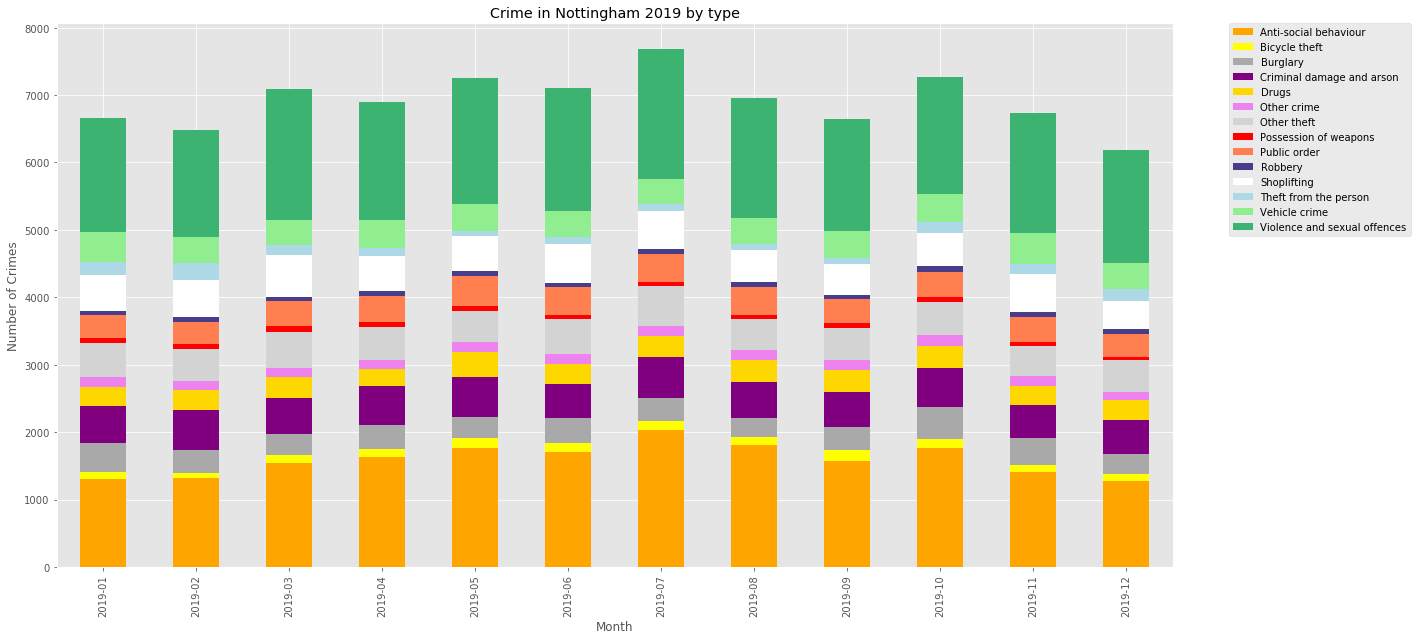

In [146]:
NOTTM_MONTH_CRIME=NOTTM_CRIME_MONTH.transpose() 
NOTTM_MONTH_CRIME.drop(index='Total', inplace = True)   # We don't need to include the Total column in the graph.

NOTTM_MONTH_CRIME.plot(kind='bar', 
             stacked=True,
             figsize=(20, 10), # pass a tuple (x, y) size
             #colormap = tab20b,
             color=['orange','yellow','darkgrey','purple','gold','violet','lightgrey','red','coral','darkslateblue','white','lightblue','lightgreen','mediumseagreen']
             )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Crime in Nottingham 2019 by type')
plt.ylabel('Number of Crimes')
plt.xlabel('Month')

plt.show()

## (b)  Crime in Nottingham by Month, by Borough

Having loaded data for the crimes per month (Crime Seasonality) we should review this in graphical format.

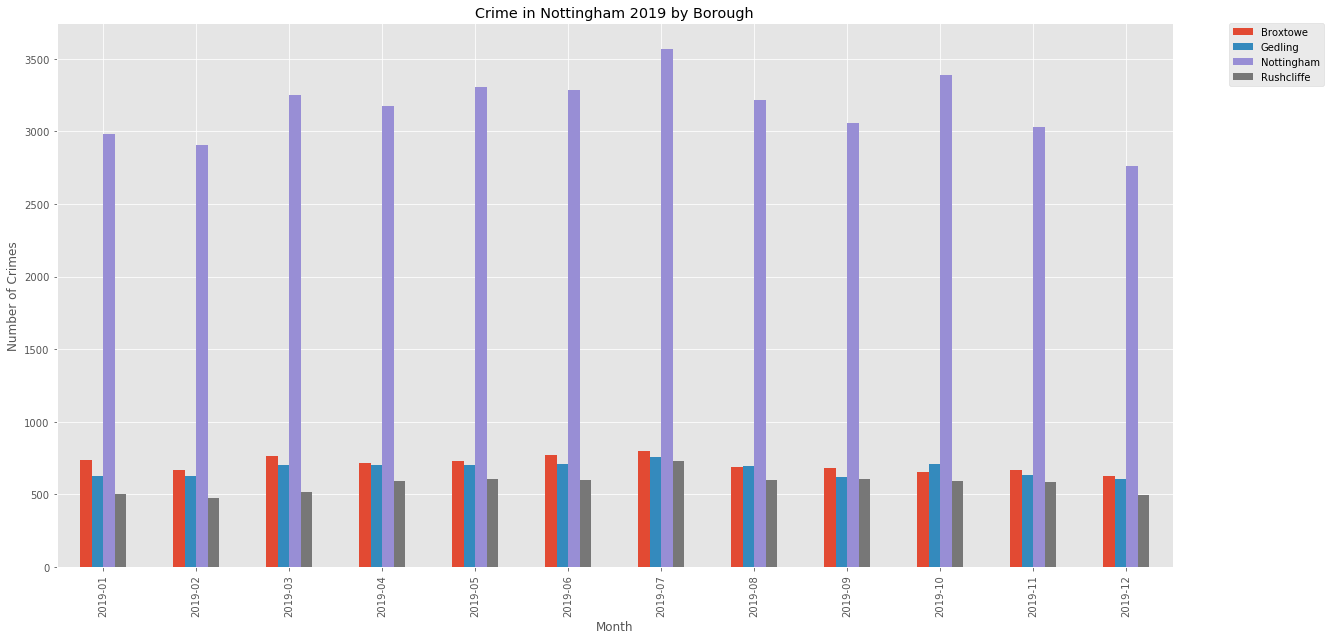

In [147]:
NOTTM_MONTH_BORO_CRIME=NOTTM_CRIME_BORO_MONTH.transpose()
NOTTM_MONTH_BORO_CRIME.drop(index='Total', inplace = True)

NOTTM_MONTH_BORO_CRIME.plot(kind='bar', 
             stacked=False,
             figsize=(20, 10), # pass a tuple (x, y) size
             )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Crime in Nottingham 2019 by Borough')
plt.ylabel('Number of Crimes')
plt.xlabel('Month')

plt.show()

## (c)  Crime in Nottingham by Crime Type by Borough.

Having loaded data for the crimes by crime type broken down by Borough we should review this in graphical format.

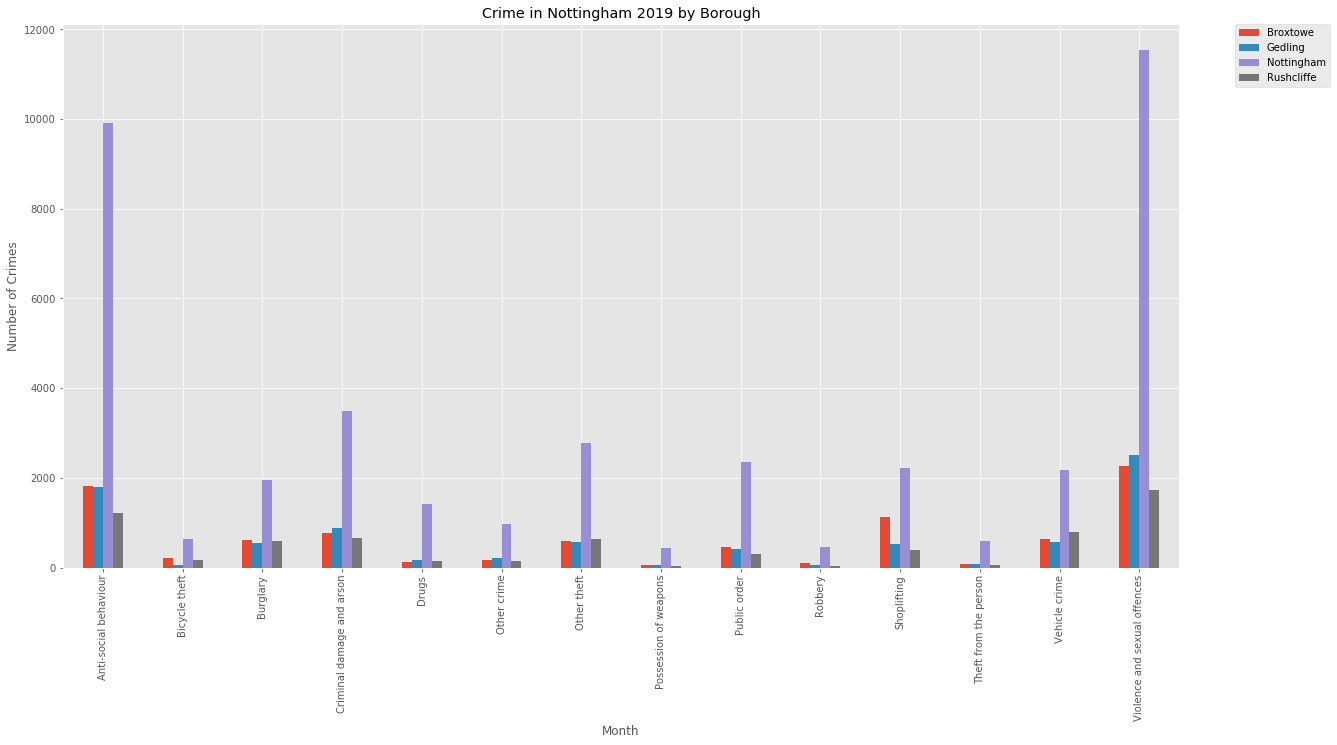

In [148]:
NOTTM_CRIME_CT_BORO = NOTTM_CRIME_BORO_CT.transpose()
NOTTM_CRIME_CT_BORO.drop(index='Total', inplace = True)
NOTTM_CRIME_CT_BORO.plot(kind='bar', 
             stacked=False,
             figsize=(20, 10), # pass a tuple (x, y) size
             )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Crime in Nottingham 2019 by Borough')
plt.ylabel('Number of Crimes')
plt.xlabel('Month')

plt.show()

## (d)	Clustering all LSOAs by Crime rate and venue frequency

The results of grouping all of the LSOAs gives the following groups:-

In [152]:
LSOA_CRIME_VENUE_TRM.groupby('Crm_Ven Cluster').agg({'Crime_Std': [np.mean,np.std],'Venue_Std': [np.mean,np.std],'Crm_Ven Cluster': np.size})

Crime_Std            Venue_Std           Crm_Ven Cluster
                      mean       std       mean       std            size
Crm_Ven Cluster                                                          
0                 1.488419  1.223820   3.465132  1.249175              61
1                 0.752559  0.563613   0.228089  0.428616             330
2                14.333932  4.143845  28.354922  2.187268               2
3                15.358642       NaN   7.217617       NaN               1
4                 3.708872  1.570840  11.857513  5.357691               4

In the above table the Standardised Crime factor ('Crime_Std') shows the multiples of the average crimes per LSOA that are the average for LSOAs in that group.  Similarly, the value of "Venue_Std" reflects the multiples of the average venue per LSOA that characterises the average LSOA in the group. 

These groups can be assigned appropriately to each of the LSOAs and this can be shown on a map of Nottingham:- 

In [155]:
# create map of Nottingham using latitude and longitude values
LSOA_CV_Map_Nottm = folium.Map(location=[Nottm_latitude, Nottm_longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(LSOA_CRIME_VENUE['LATITUDE'], LSOA_CRIME_VENUE['LONGITUDE'], LSOA_CRIME_VENUE['LSOA_Name'], LSOA_CRIME_VENUE['Crm_Ven Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(LSOA_CV_Map_Nottm)
       
LSOA_CV_Map_Nottm

## (e)	Clustering LSOAs with venues by Crime rate and venue frequency
The results of grouping the LSOAs that have a venue on them give the following groups:-

In [153]:
# LSOA_VENUE_CRIME_TRM.groupby('Crm_Ven Cluster').mean()
LSOA_VENUE_CRIME_TRM.groupby('Crm_Ven Cluster').agg({'Crime_Std': [np.mean,np.std],'Venue_Std': [np.mean,np.std],'Crm_Ven Cluster': np.size})

Crime_Std            Venue_Std           Crm_Ven Cluster
                      mean       std       mean       std            size
Crm_Ven Cluster                                                          
0                 0.702781  0.347323   0.683553  0.497280             101
1                14.333932  4.143845  10.045337  0.774886               2
2                 4.234425  1.388939   2.785298  1.981001               8
3                 2.223362  0.619093   0.932106  0.539921              29
4                15.358642       NaN   2.556995       NaN               1

In the above table the Standardised Crime factor ('Crime_Std') shows the multiples of the average crimes per LSOA (calculated for all LSOAs in the Nottingham urban Area) that are the average for all LSOAs in that group.  Similarly, the value of 'Venue_Std' reflects the multiples of the average venue per LSOA that is the characterise the average LSOA in the group. Standard deviation for the mean od the averaages in the groups is shown under "std" column for each metric.

These groups can be assigned appropriately to each of the LSOAs and this can be shown on a map of Nottingham:- 

In [154]:
# create map of Nottingham using latitude and longitude values
LSOA_VC_Map_Nottm = folium.Map(location=[Nottm_latitude, Nottm_longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(LSOA_VENUE_CRIME['LATITUDE'], LSOA_VENUE_CRIME['LONGITUDE'], LSOA_VENUE_CRIME['LSOA_Name'], LSOA_VENUE_CRIME['Ven_Crm Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(LSOA_VC_Map_Nottm)
       
LSOA_VC_Map_Nottm

## Discussion <a name="Discussion"></a>

### - Data
The use of the Lower Super Output Areas (LSOAs) was driven by the use of these units in the Crime data provided by the UK Police portal.  Initial doubts regarding the large number number of LSOAs proved incorrect, as the use of MSOAs did not provide the required level of detail in the granularity of the geographical units.

The Foursquare data does appear to be incomplete for Nottingham.  For example, the data does not include Nottingham’s premier restaurant, Sat Bains.  This would be an interesting restaurant to include in the grouping as it is situated away from other venues in a relatively isolated site.  Indeed, it can be found on the maps provided, but the site does not appear as a data point – unlike an adjacent venue which appeared before the data was filtered for restaurant venues.   However, Sat Bains would have been an interesting outlier for the K-means cluster modelling but given that this is a “destination venue” it may well be the case that in practice, the restaurant could be placed anywhere in Nottingham with easy access to the main roads.   Nevertheless, other venues that exist in Nottingham are missing, particularly in the more outlying areas.

However, the omission is concerning and further work could be required to understand if this is a factor of how the Foursquare data is gathered and the demographic of the people doing the gathering or any other related reasons.


### - Results
The first three parts of the results have been put together in order to review the overall nature of crime and how it is distributed in the greater Nottingham urban area.  The last two points discuss the results of the groupings of the various LSOAs based on crime and venue frequency in the greater Nottingham area. 

(a)	Crime in Nottingham by Month, by Crime Type.
The variation in the monthly crime figures is proportionally small – meaning that the figures are quite regular with small variation.  Looking at the breakdown of the results by crime type, these too appear to have only small variation within them, appearing to have practically the same proportions each month. 

(b)	Crime in Nottingham by Month by Borough
Given that the data here is shown by borough and not detailed by LSOA this graph still imparts some information – the Borough of Nottingham has disproportionately more crime reported than the outlying boroughs.  Whilst population density may be a factor (the figures are not used here) it is also worth noting that Nottingham has a busy city centre and people travel in.  Clearly some of those people commit crimes when they travel in.

(c)	Crime in Nottingham by Crime Type by Borough
Again, this graph is only displayed at the level of Borough and as such the detail of the individual LSOAs is not available.  Once again, the Borough of Nottingham dominates the number of crimes but the proportionality between the boroughs appears to be retained, with a slight proportional increase for shoplifting in Broxtowe and a proportional drop for vehicle crime in Nottingham.  

(d)	Clustering all LSOAs by Crime rate and venue frequency
The K-means clustering gives the following groups:-

Group 0 – This group is characterised by having a slightly higher than average crime rate and a higher than average frequency of restaurants.  There are 61 LSOAs in this group and reviewing this on the map shown in the results (LSOAs in this group are red) these LSOAs represent mains streets in some of the sub-urban town centres – as opposed to the main city centre.

Group 1 – This group of LSOAs is characterised by a lower than average crime rate with practically zero restaurant frequency.    On the map for this, the purple LSOAs are the mainly residential outer suburbs.

Group 2 – This group is characterised by a very high crime rate and also a very high  frequency of restaurants.  On the map, the 2 LSOAs in this group are in the City Centre. 

Group 3 – There is one LSOA in this group – shown in green on the map very close to the city centre.  LSOA has a very high crime rate and also shows a significantly higher than average restaurant frequency.

Group 4 – This group is characterised by a relatively high crime rate but also a high frequency of restaurants.  On the map these LSOAs are shown in yellow and are very close to the city centre, on the eastern side.

(e)	Clustering LSOAs with Restaurants by Crime Rate and venue frequency.
The grouping of those LSOAs with a restaurant venue represents a more focussed approach to examining and characterising the areas of Nottingham that have a venue present.  As stated before, the number here represent (i) for Crimes the 1 = the average crime rate across all LSOAs in the Nottingham Urban Area.   The number given to the LSOA represents a multiple of that aver age rate.  (ii) for Venues 1 = the average frequency of restaurants calculated across all LSOAs that have a restaurant in them.  The number assigned to the LSOA in this case is a multiple of that average.  

This grouping would be useful analysis for stakeholder who want to site their location in proximity to existing locations.  The K-means clustering has given the following groups:-

Group 0 – This group is characterised by a lower than average crime rate and venue frequency.  Looking at the map the red LSOAs are distributed over the town centres of the Nottingham suburbs. 

Group 1 – This group of LSOAs is characterised by very high crime rate and very high venue frequency.  On the map the 2 LSOAs in the group are the green ones in the city centre.	

Group 2 – This group is characterised by a relatively high multiples of crime rate and a higher venue frequency.  On the map these LSOAs are the blue ones mainly distributed around the city centre.

Group 3 – These LSOAs have double the average crime rate and a roughly average venue frequency.  On the map these LSOAs show as green and are distributed around the suburban area.

Group 4 – There is one LSOA in this groups – characterised by a very high crime rate with double the average venue frequency.  On the map the yellow LSOA appears quite close to the city centre.
 

## Conclusion <a name="Conclusion"></a>

The clustering of the LSOAs using crime rate and grouping of the various LSOAs would show that there is a huge increase in the crime rate in Nottingham City Centre and at the same time this is where there is a the greatest density of restaurants.  This shows that many restaurants exist in areas with high crime rates.  It is not suggested that there is a causal link – more a case that restaurants are more successful where there are more people, and where there is more people, there is more crime.  Undoubtedly Nottingham City centre attracts a great many people.

The use of the first grouping of LSOAs is supported by the second – which represents a refinement of the first model.
However there is no clear recommendation of which area that a stakeholder would want to site a potential business in.  The model would give them a chance to understand the groups and then examine the potential of an LSOA based on crime rate and locally existing restaurants.  The approach used works best if the stakeholder want to be co-located with other restaurants.

The model could be improved by incorporating the following:-

Foursquare premium services need to be incorporated – particularly the number of check-ins and customer rating.

Cost information such as Business rate, Rents, Insurance rates etc.


The addition of such information would give a user more information in order to optimise the choice of LSOA for the location of a potential . 
